In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce ETV Result for KIC 8043961

- also known as TIC 272609309

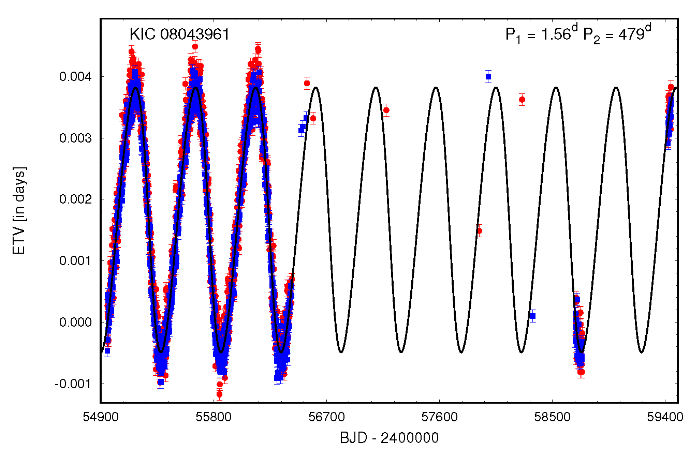

Source: [Eclipsing Binaries in Dynamically Interacting Close, Multiple Systems](https://ui.adsabs.harvard.edu/abs/2022Galax..10....9B/abstract)

In [5]:
# define the plotting parameters

figsize = (8,4)

In [3]:
# import the data

# choose a TIC ID to analyze
ticid =  272609309  #  aka KIC 8043961, a multi star close EB sytem, with known ETV, amplitude of ~7.2min (0.005d) in Kepler data
kicid = 8043961
# reference: https://www.mdpi.com/2075-4434/10/1/9
# 
# TODO: consider to include Kepler data

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (sector 5)
sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
search_result = sr.download_all().stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 14 2019   SPOC     120   272609309      0.0     G022062
  1 TESS Sector 15 2019   SPOC     120   272609309      0.0     G022062
  2 TESS Sector 41 2021   SPOC     120   272609309      0.0      G04171
  3 TESS Sector 54 2022   SPOC     120   272609309      0.0      G04171
  4 TESS Sector 55 2022   SPOC     120   272609309      0.0      G04171

91276

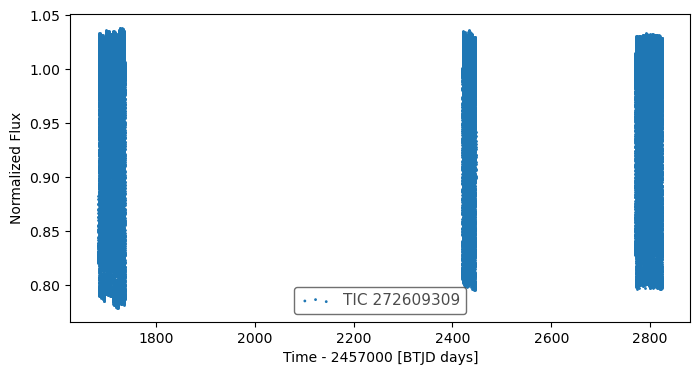

In [6]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# t0 = 2337.376
# period_triple = 0.774

mask = time < 0  # (time > 2893.16-1) & (time < 2893.16+1) 

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})


In [8]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [7]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

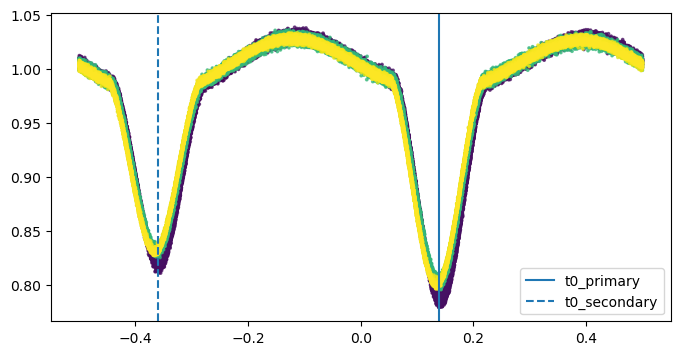

In [76]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# caught both primary and secondary
# epoch=1683.4147, duration_hr=5.5736, period=0.779466, label="s0014-s0055:TCE1",
# Given it has known ETV, I used  1.5604812 (as the variation might confuse the period derived from a longer base line)
# VSX period: 1.559231 , TESS EB period (S14,15): 1.5592013928014403
# period = np.mean([0.781250, 0.781250, 0.779620, 0.779623, 0.779460]) * 2  the mean of period of single sector TCEs,
period = 1.559231  # VSX Period fits the best

# from TCE
# t0_primary = 1683.4147 + period /2
# t0_secondary = 1683.4147 

# from TESS EB
# the 0.004 offset is added after visual inspection of the folded data with the inital guess model, to center the eclipses
t0_primary = 1684.1910518955988 - 0.004
t0_secondary = 1684.1910518955988 - period / 2 - 0.004

duration_hr_primary = 5.5736  # used for the window to cut the lighcurve around eclipses in later cells
duration_hr_secondary = 5.5736

t0_for_plotting = 0  # keep 0 for plotting purposes
# t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.25  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

### Now that the data is ready we can start 

In [71]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase  flux_sub_binary  \
0      1683.356398  0.882110  0.001402 -0.393195         0.006911   
1      1683.357787  0.879668  0.001402 -0.392304         0.006784   
2      1683.359176  0.875167  0.001400 -0.391414         0.004586   
3      1683.360565  0.875280  0.001398 -0.390523         0.006976   
4      1683.361954  0.869127  0.001396 -0.389632         0.003065   
...            ...       ...       ...       ...              ...   
89960  2824.259976  1.015366  0.001289  0.315947         0.000874   
89961  2824.261365  1.013582  0.001288  0.316838        -0.001152   
89962  2824.262754  1.013117  0.001288  0.317729        -0.001859   
89963  2824.264142  1.012913  0.001288  0.318619        -0.002303   
89964  2824.265531  1.014244  0.001289  0.319510        -0.001210   

       binary_model  flux_detrended  
0          0.875199        0.876872  
1          0.872883        0.874457  
2          0.870581        0.869982  
3          0.868304        0.870127  
4          0.866062        0.864008  
...             ...             ...  
89960      1.014492        1.016710  
89961      1.014735        1.014925  
89962      1.014976        1.014458  
89963      1.015216        1.014253  
89964      1.015454        1.015584  

[89965 rows x 7 columns]

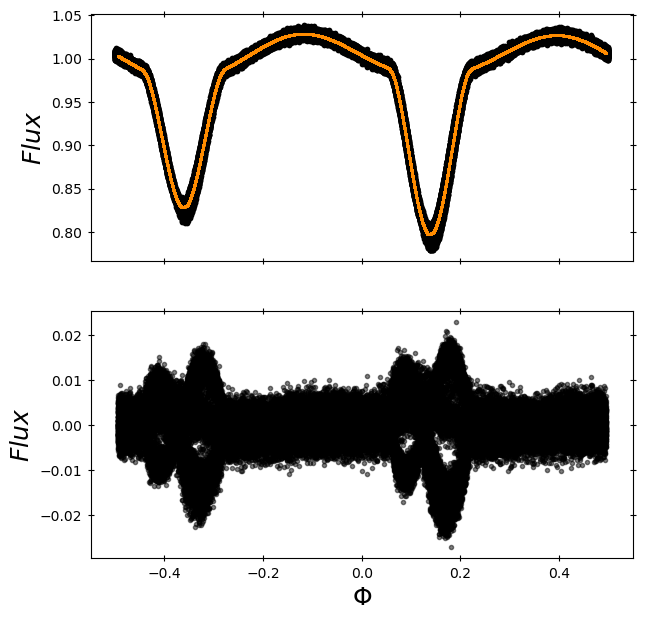

time      flux       err     phase  flux_sub_binary  \
0      1683.356398  0.882110  0.001402 -0.393195         0.006911   
1      1683.357787  0.879668  0.001402 -0.392304         0.006784   
2      1683.359176  0.875167  0.001400 -0.391414         0.004586   
3      1683.360565  0.875280  0.001398 -0.390523         0.006976   
4      1683.361954  0.869127  0.001396 -0.389632         0.003065   
...            ...       ...       ...       ...              ...   
89960  2824.259976  1.015366  0.001289  0.315947         0.000874   
89961  2824.261365  1.013582  0.001288  0.316838        -0.001152   
89962  2824.262754  1.013117  0.001288  0.317729        -0.001859   
89963  2824.264142  1.012913  0.001288  0.318619        -0.002303   
89964  2824.265531  1.014244  0.001289  0.319510        -0.001210   

       binary_model  flux_detrended  
0          0.875199        0.876872  
1          0.872883        0.874457  
2          0.870581        0.869982  
3          0.868304        0.870127  
4          0.866062        0.864008  
...             ...             ...  
89960      1.014492        1.016710  
89961      1.014735        1.014925  
89962      1.014976        1.014458  
89963      1.015216        1.014253  
89964      1.015454        1.015584  

[89965 rows x 7 columns]

In [77]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 89085 901
reached the end
10 80027 901
reached the end
10 76813 901
reached the end
10 75950 901
reached the end
10 75731 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      1683.356398  0.882110  0.001402 -0.393195         0.006911   
1      1683.357787  0.879668  0.001402 -0.392304         0.006784   
2      1683.359176  0.875167  0.001400 -0.391414         0.004586   
3      1683.360565  0.875280  0.001398 -0.390523         0.006976   
4      1683.361954  0.869127  0.001396 -0.389632         0.003065   
...            ...       ...       ...       ...              ...   
89960  2824.259976  1.015366  0.001289  0.315947         0.000874   
89961  2824.261365  1.013582  0.001288  0.316838        -0.001152   
89962  2824.262754  1.013117  0.001288  0.317729        -0.001859   
89963  2824.264142  1.012913  0.001288  0.318619        -0.002303   
89964  2824.265531  1.014244  0.001289  0.319510        -0.001210   

       binary_model  flux_detrended  
0          0.875199        0.876872  
1          0.872883        0.874457  
2          0.870581        0.869982  
3          0.868304        0.870127  
4          0.866062        0.864008  
...             ...             ...  
89960      1.014492        1.016710  
89961      1.014735        1.014925  
89962      1.014976        1.014458  
89963      1.015216        1.014253  
89964      1.015454        1.015584  

[89965 rows x 7 columns]

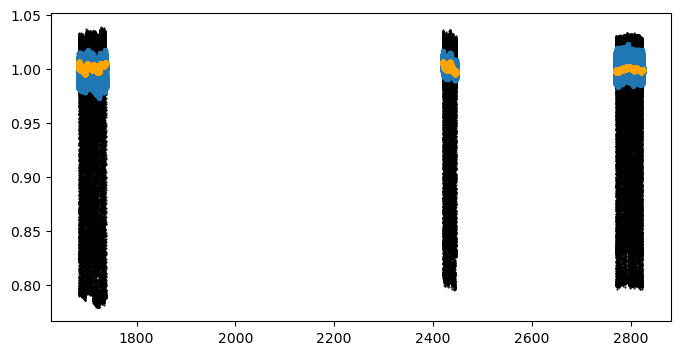

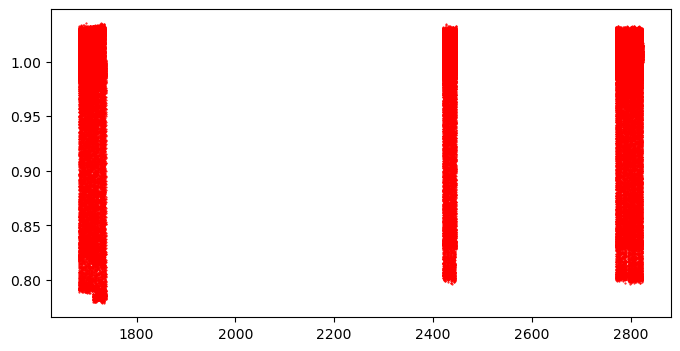

In [78]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

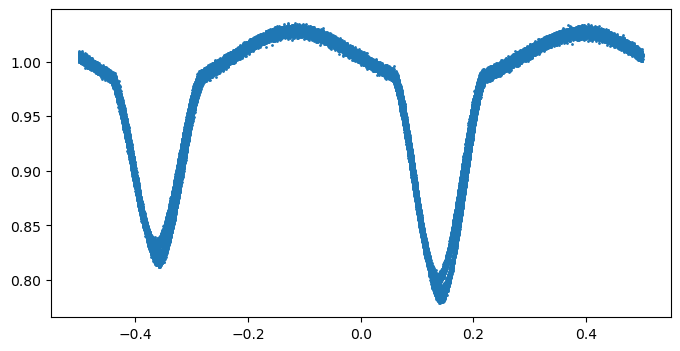

In [74]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   1684.1870518955989 0.13953794889836268
window_width_p (phase): 0.095
Secondary: 1683.4074363955988 -0.3604620511016956
window_width_s (phase): 0.095


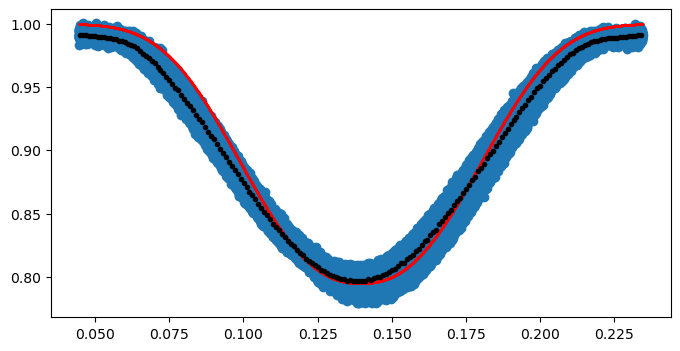

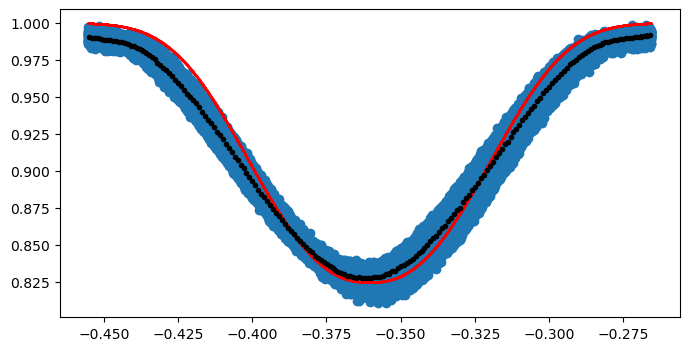

In [79]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
# window_width_p = 1.2 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    # window_width_s = 1.2 * duration_hr_secondary / 24 / period
    window_width_s = 0.095
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1, -0.205, midpoint_p, 0.035, 1.2]
start_vals_s = [1, -0.175, midpoint_s, 0.035, 1.2]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

100%|██████████████████████████████████████████████████████████| 1000/1000 [04:26<00:00,  3.75it/s]


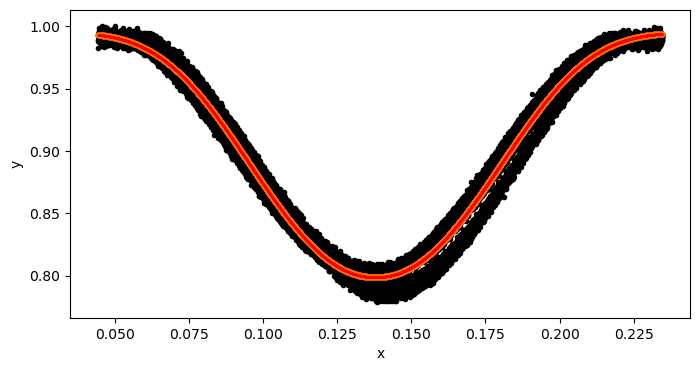

100%|██████████████████████████████████████████████████████████| 1000/1000 [04:41<00:00,  3.55it/s]


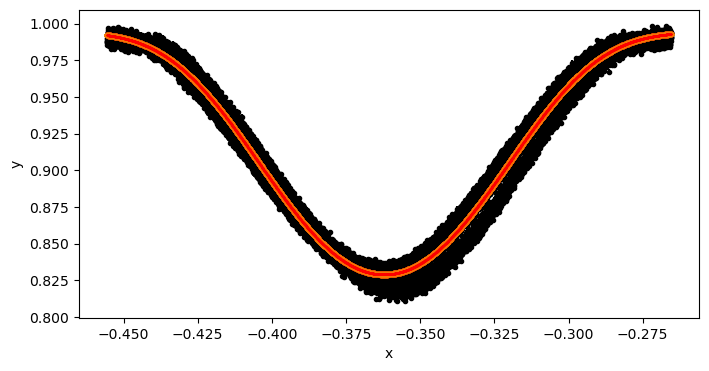

In [80]:
# run the initial model fit using MCMC for the primary and secondary eclipses 

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
if t0_secondary is not None:
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
!$NOTIFY_CMD "Initial fit done"

731

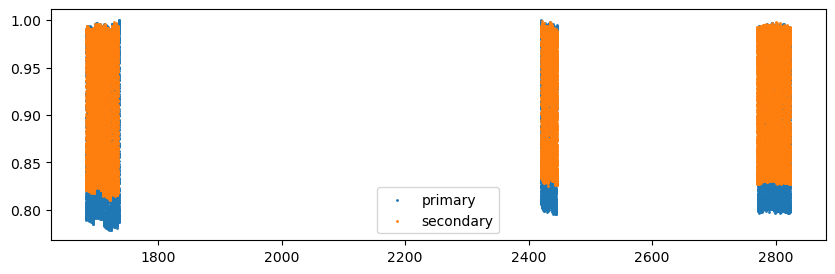

In [81]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1684.1870518955989 1.559231 1684.1870518955989


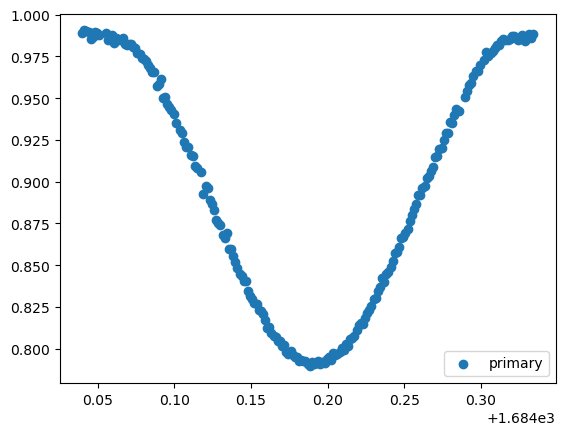

1684.1870518955989 1.559231 1685.7462828955988


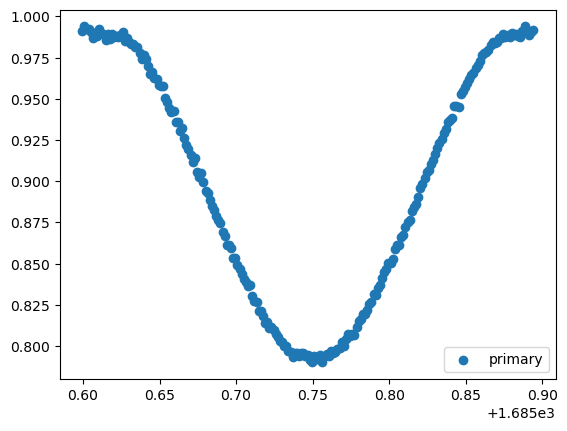

1684.1870518955989 1.559231 1687.3055138955988


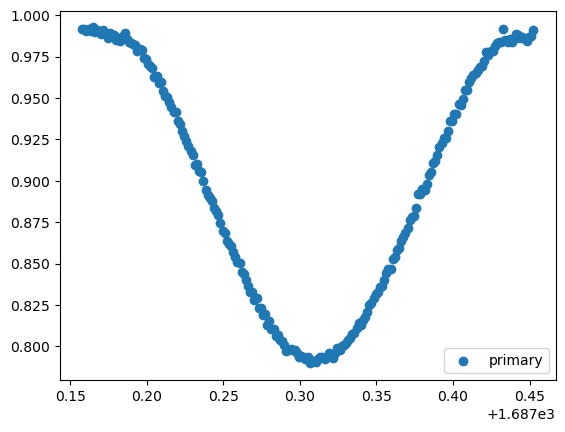

1683.4074363955988 1.559231 1683.4074363955988


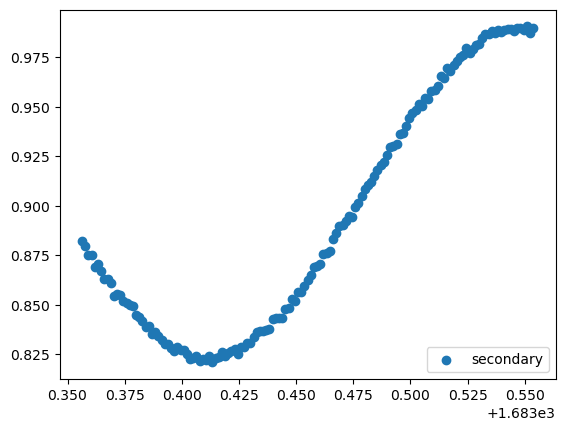

1683.4074363955988 1.559231 1684.9666673955987


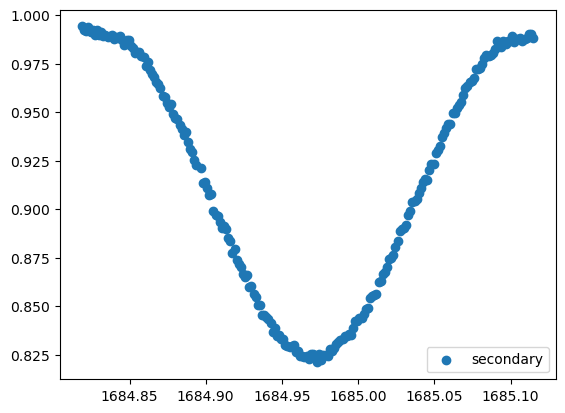

1683.4074363955988 1.559231 1686.5258983955987


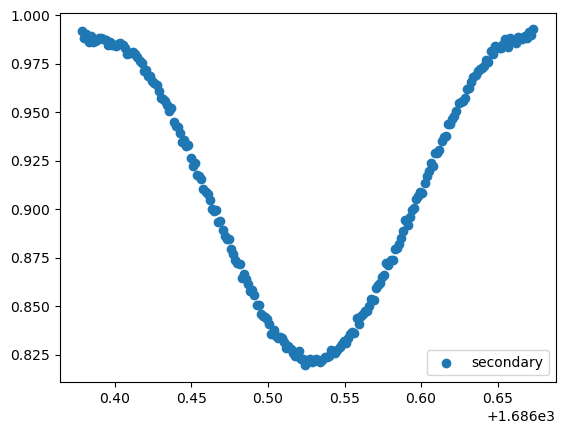

In [82]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

In [83]:
print("Primary   - Start params")
print(*start_vals)
print("Primary   - Initial params")
print(mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau)

if t0_secondary is not None:
    print("Secondary - Start params")
    print(*start_vals_s)
    print("Secondary - Initial params")
    print(mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s)

Primary   - Start params
1 -0.205 0.13953794889836268 0.035 1.2
Primary   - Initial params
0.9952805328380019 -0.19658210963617523 0.13786921181808892 0.038728322371595 1.0634952429680278
Secondary - Start params
1 -0.175 -0.3604620511016956 0.035 1.2
Secondary - Initial params
0.9942509461053578 -0.16521715024221129 -0.3621991361211707 0.03940754629536868 1.0173790255210255


Fitting individual primary eclipses...
Creating new manifest file
1684.1870518955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1311.86it/s]


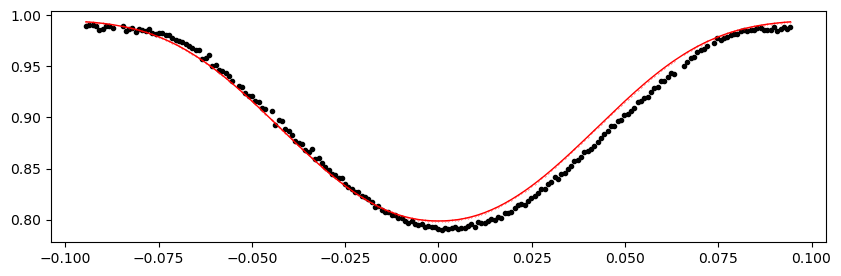

1685.7462828955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1287.96it/s]


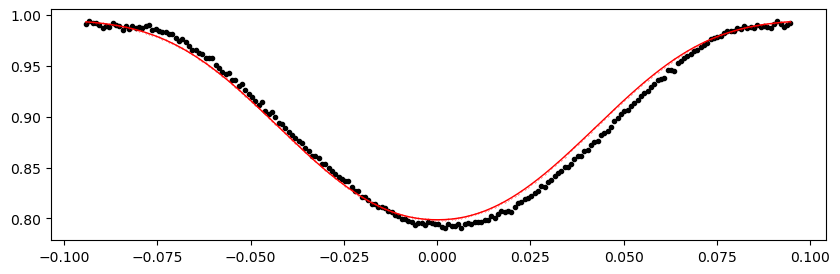

1687.3055138955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1319.96it/s]


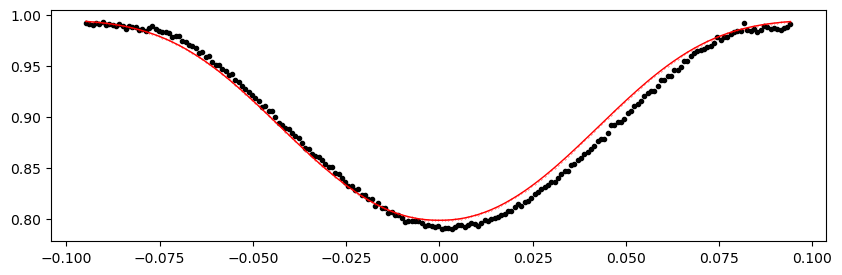

1688.864744895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.60it/s]


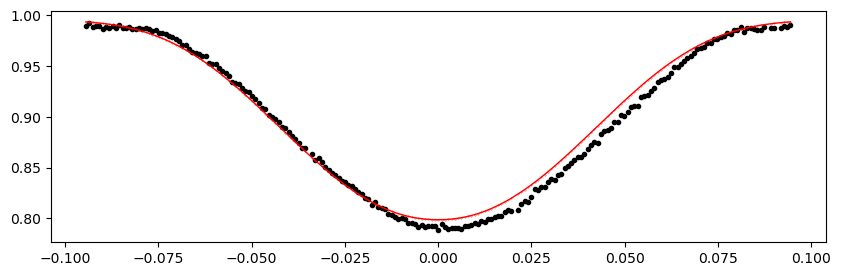

1690.423975895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1323.01it/s]


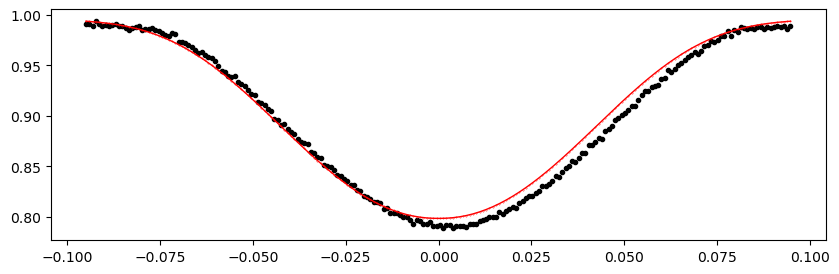

1691.9832068955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.93it/s]


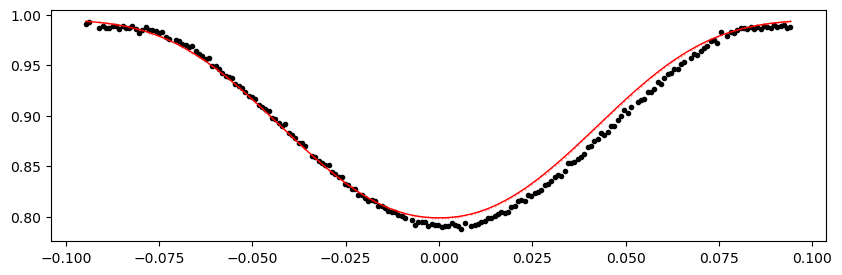

1693.5424378955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.75it/s]


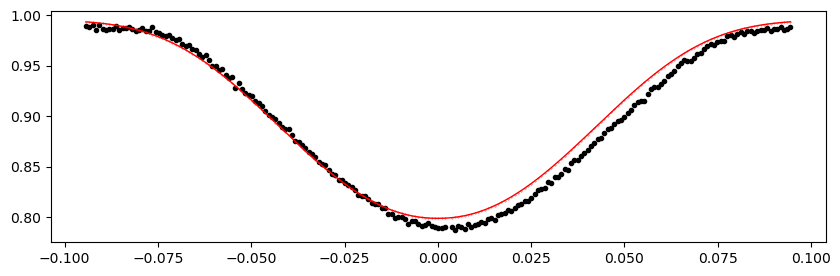

1695.1016688955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1329.79it/s]


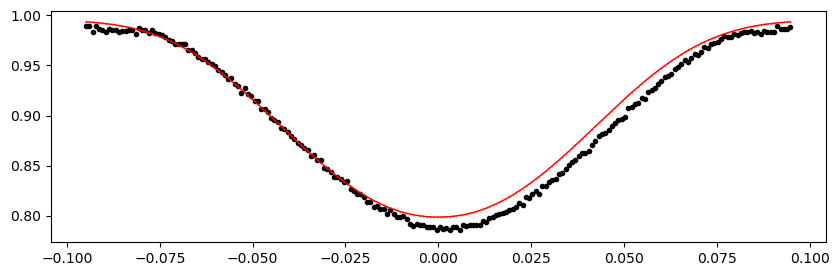

1698.220130895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.57it/s]


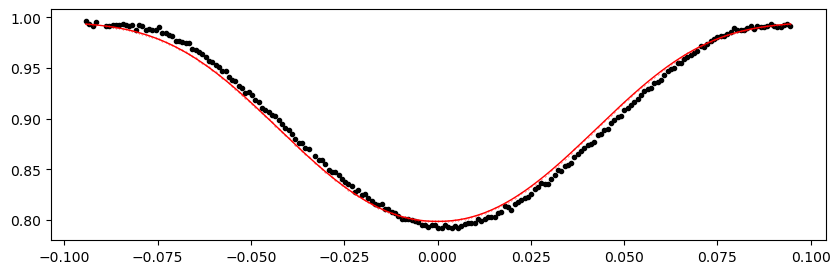

1699.7793618955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.94it/s]


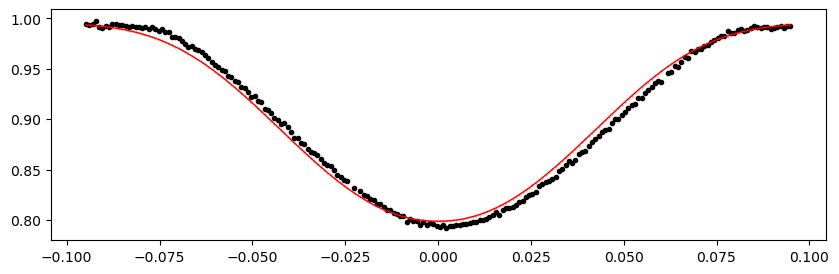

1701.3385928955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.69it/s]


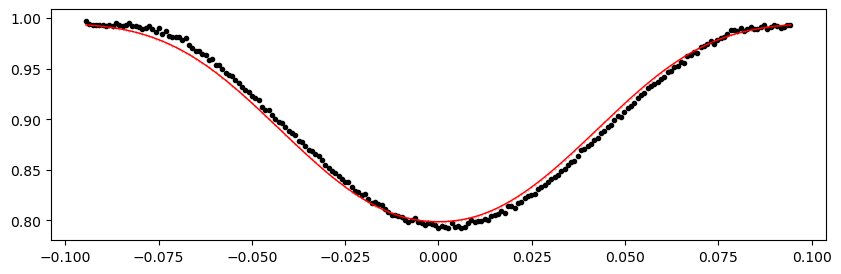

1702.8978238955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.33it/s]


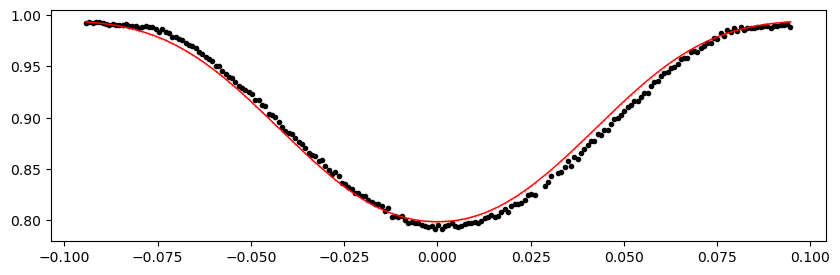

1704.457054895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.40it/s]


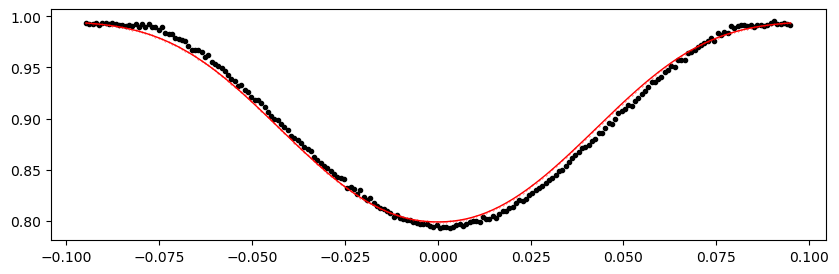

1706.016285895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.79it/s]


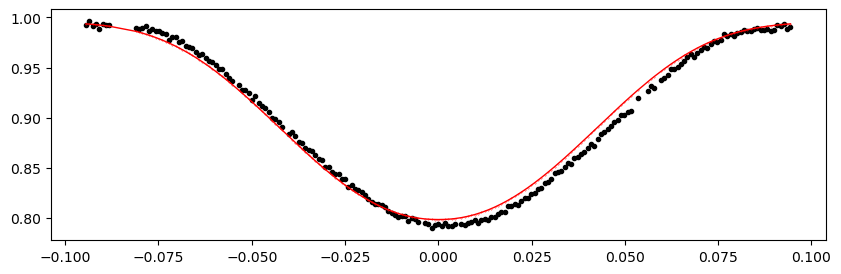

1707.5755168955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.74it/s]


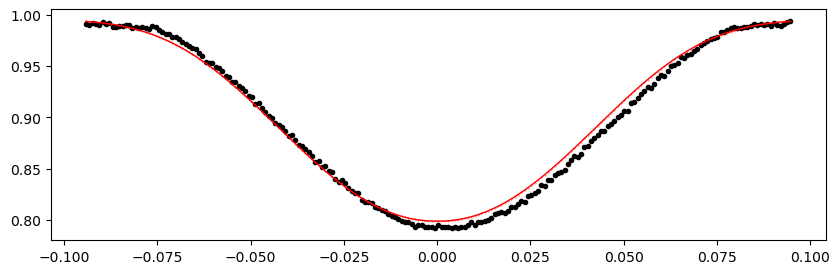

1709.1347478955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.28it/s]


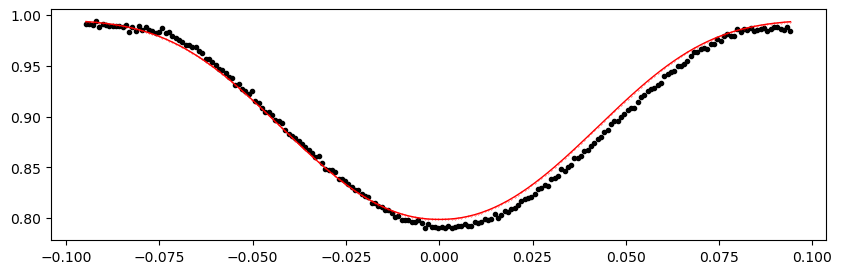

1712.253209895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1318.21it/s]


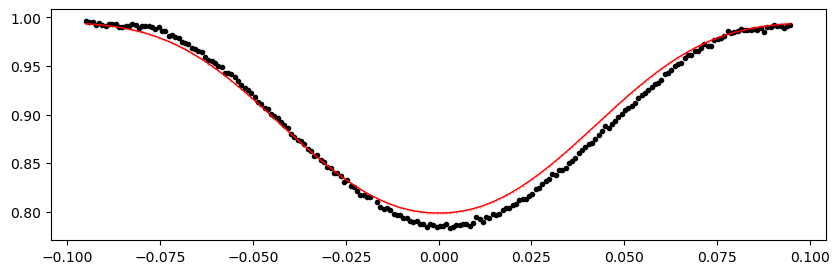

1713.812440895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1324.15it/s]


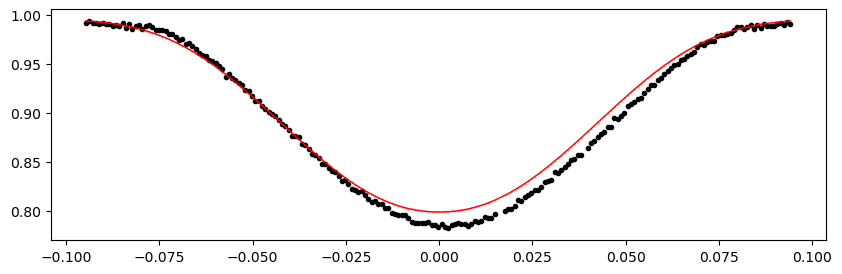

1715.3716718955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1313.18it/s]


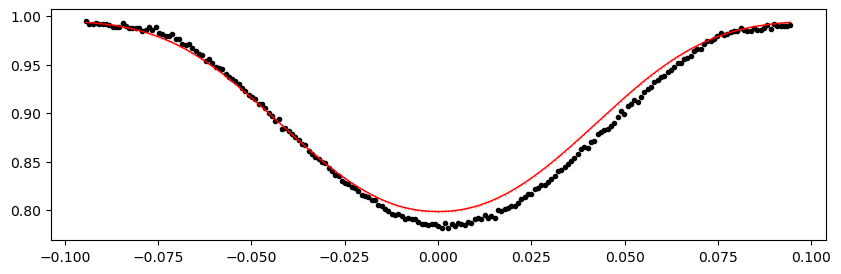

1716.9309028955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1325.31it/s]


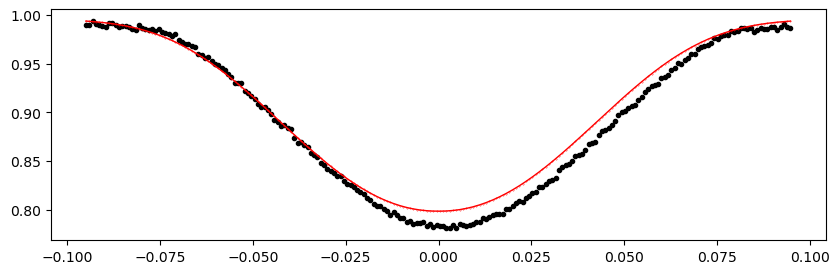

1718.4901338955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1321.67it/s]


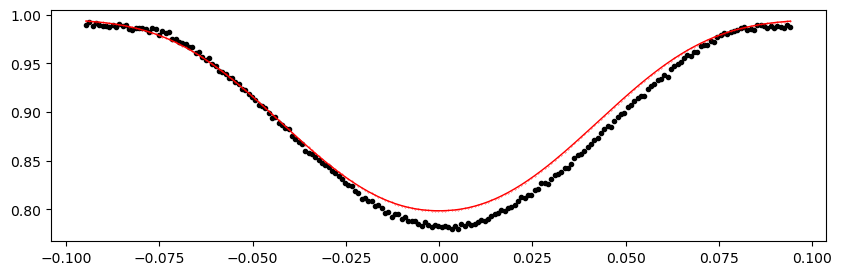

1720.049364895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1317.35it/s]


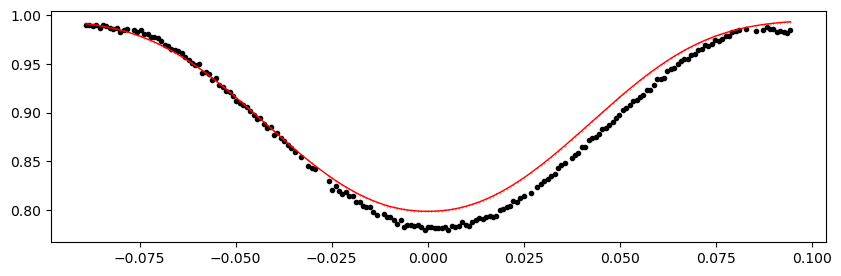

1721.608595895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1316.30it/s]


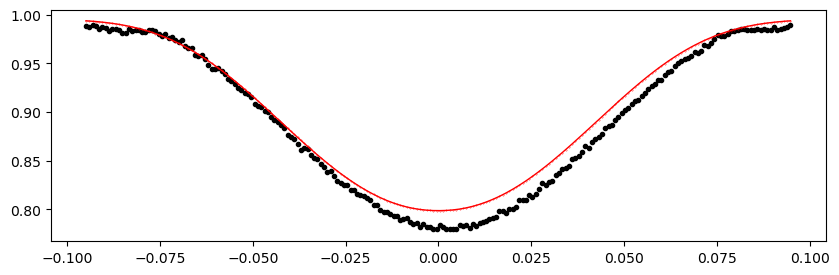

1723.1678268955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.34it/s]


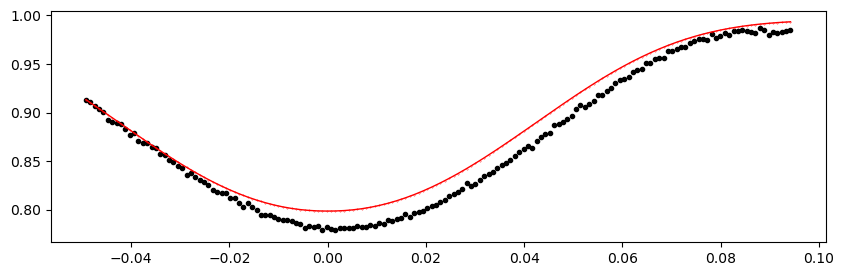

1726.2862888955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.44it/s]


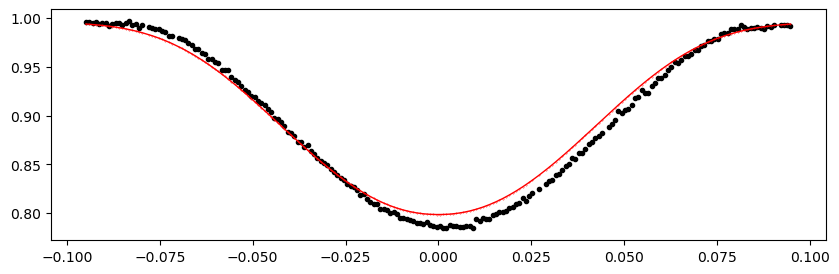

1727.845519895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1286.59it/s]


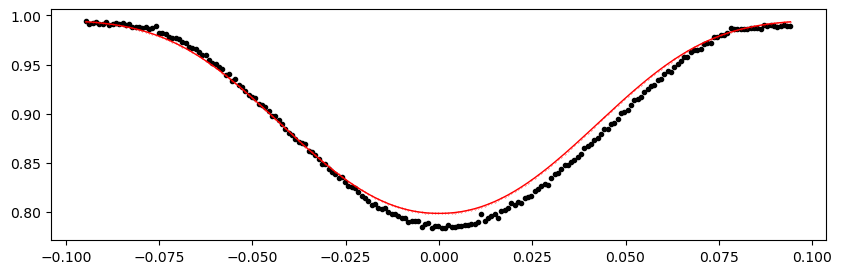

1729.404750895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.03it/s]


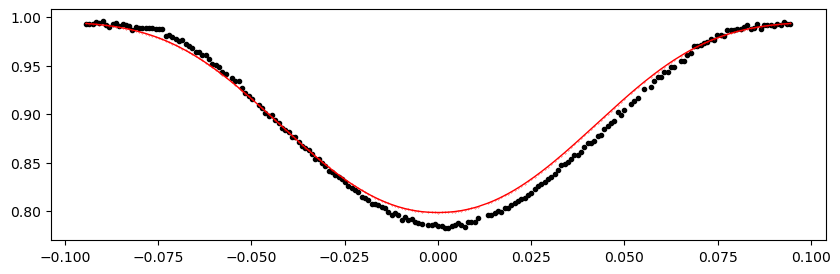

1730.9639818955989 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.03it/s]


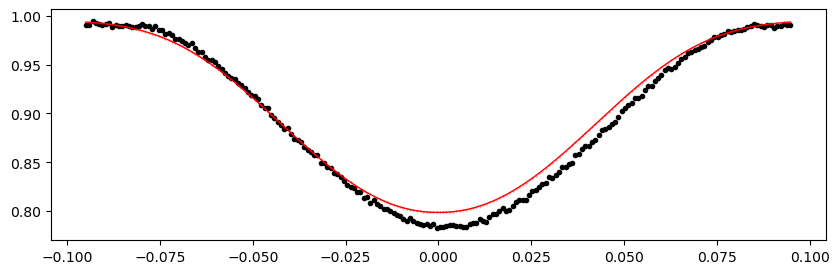

1732.5232128955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1308.88it/s]


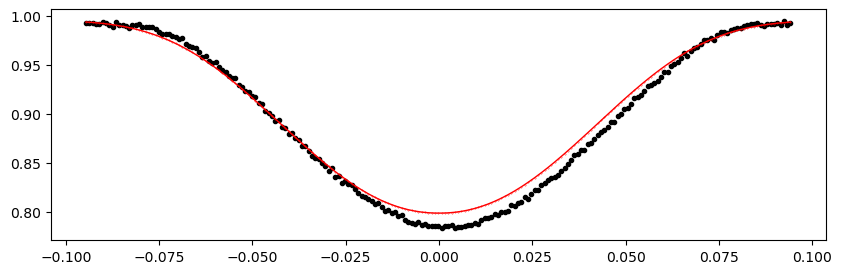

1734.0824438955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1303.44it/s]


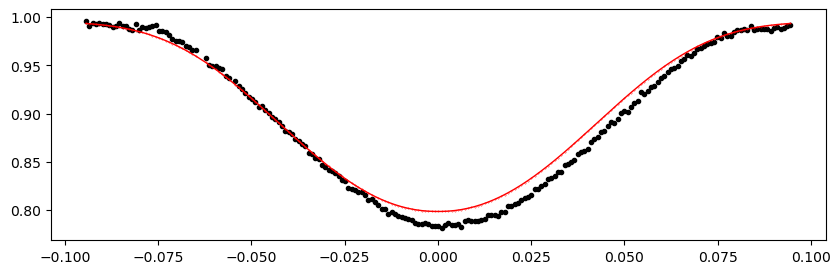

1735.641674895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.08it/s]


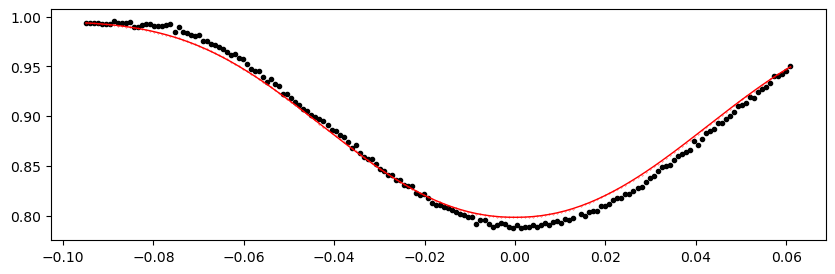

1737.200905895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.38it/s]


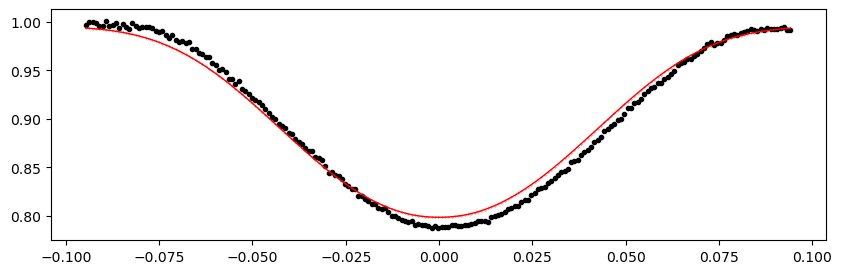

2420.1440838955987 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.67it/s]


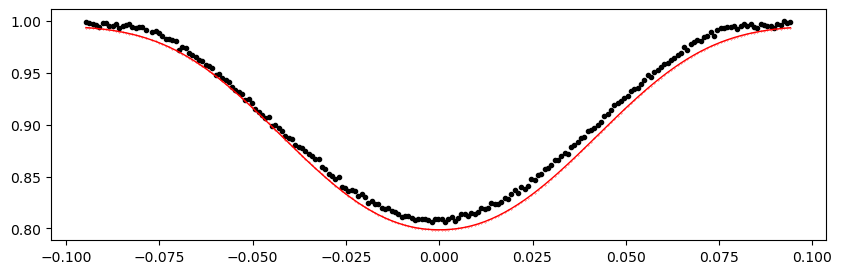

2421.703314895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.50it/s]


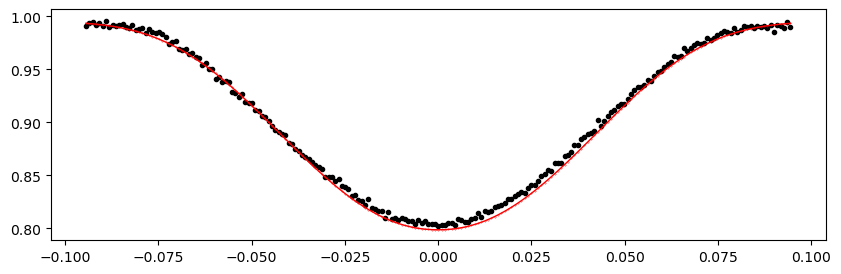

2423.262545895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.86it/s]


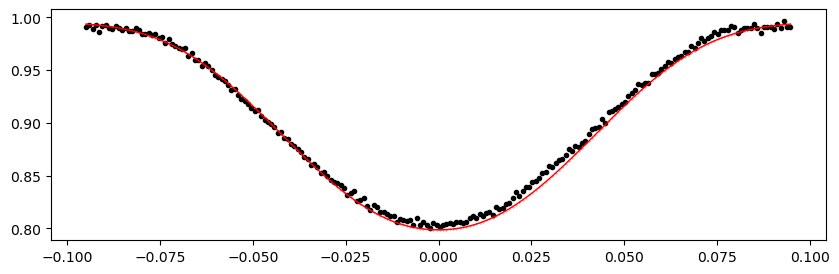

2424.8217768955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.69it/s]


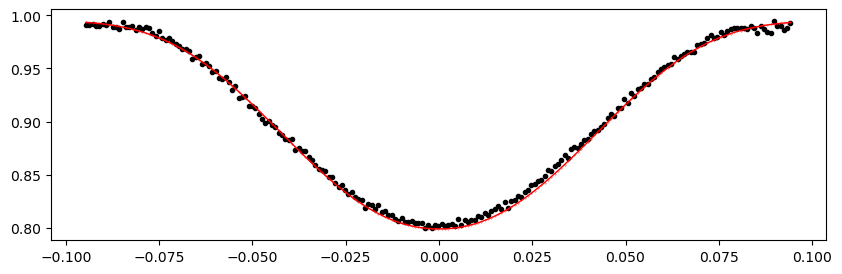

2426.381007895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.76it/s]


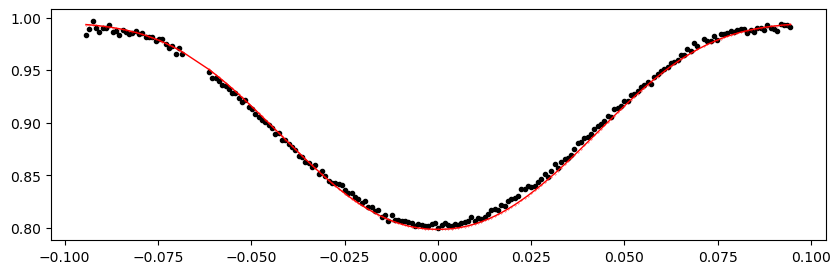

2427.9402388955987 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.45it/s]


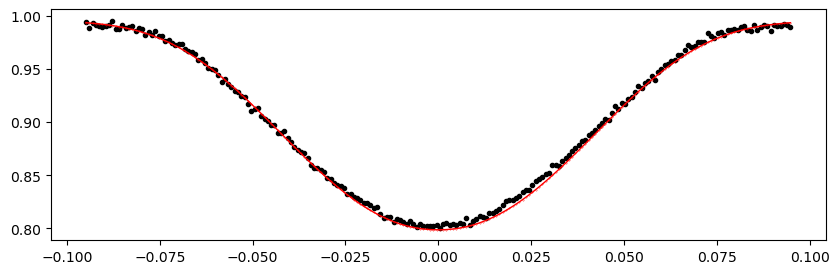

2429.499469895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.53it/s]


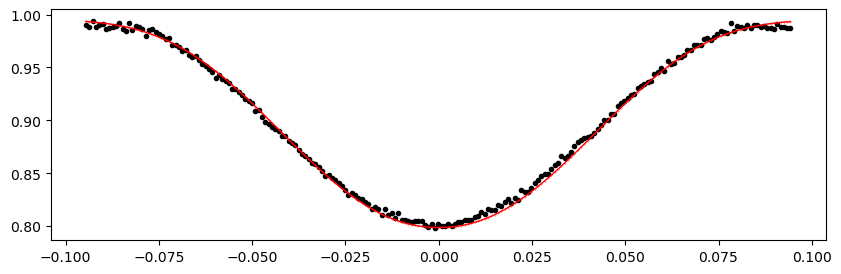

2431.058700895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.24it/s]


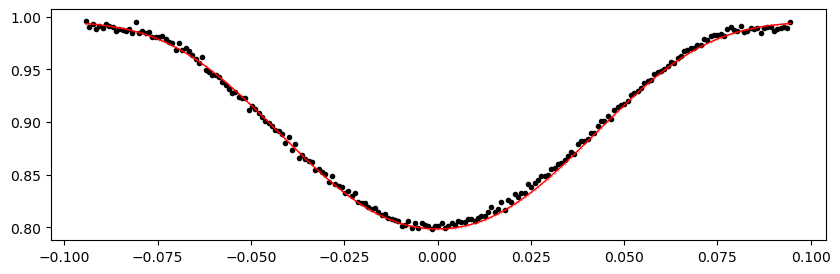

2432.6179318955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1355.85it/s]


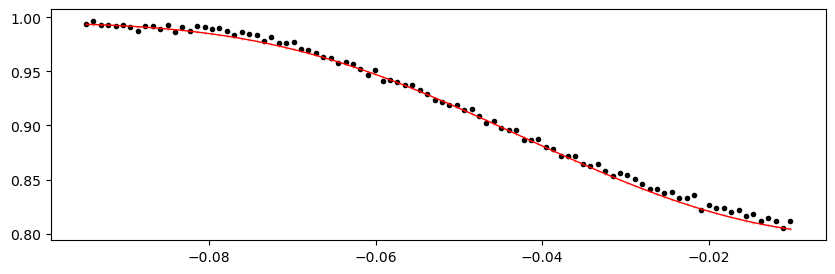

2434.177162895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.66it/s]


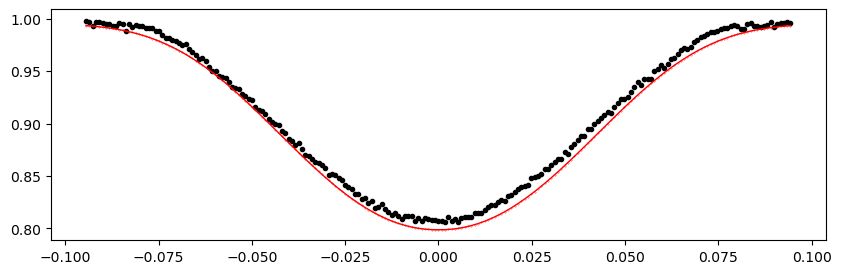

2435.7363938955987 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.55it/s]


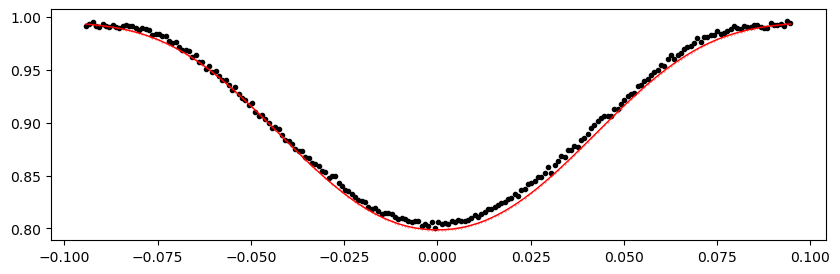

2437.295624895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.24it/s]


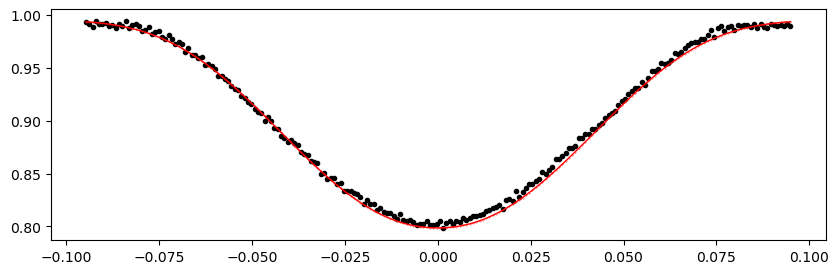

2438.854855895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.03it/s]


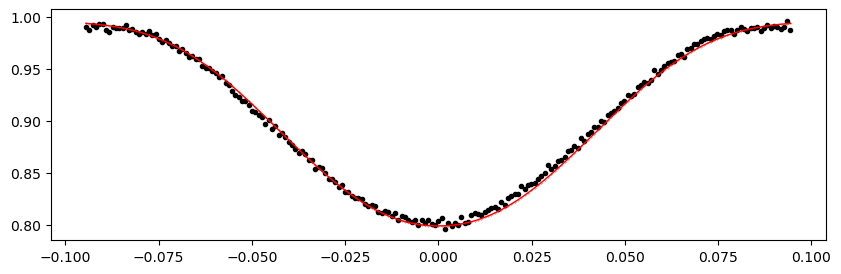

2440.4140868955988 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.21it/s]


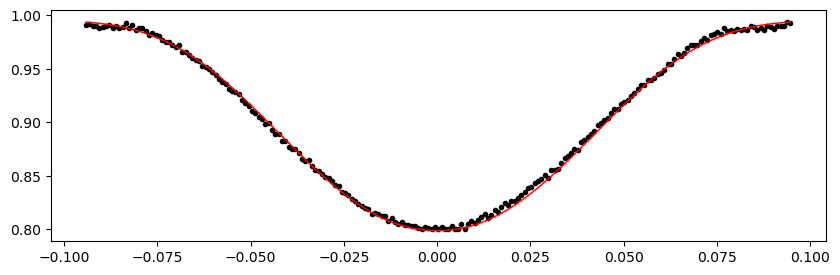

2441.973317895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.06it/s]


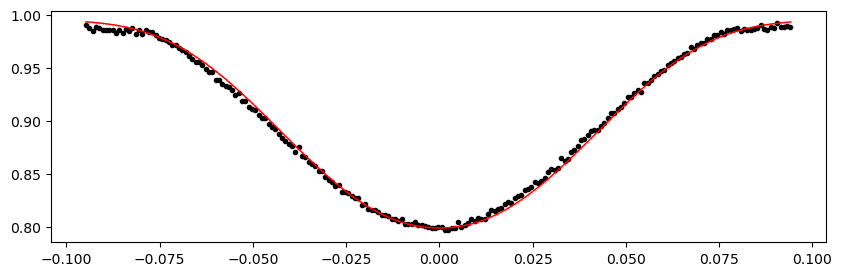

2443.5325488955987 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1315.01it/s]


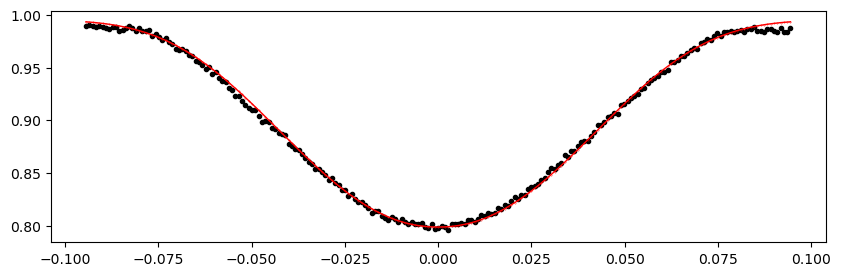

2445.091779895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.52it/s]


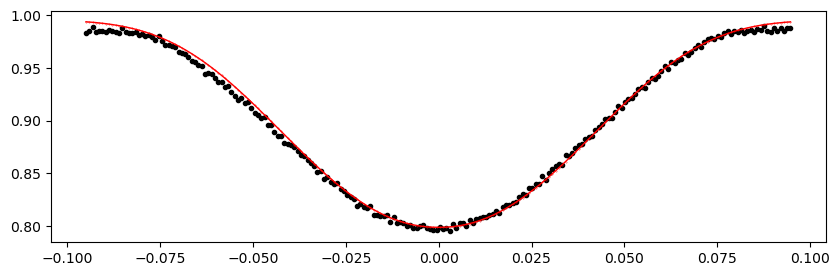

2446.651010895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.32it/s]


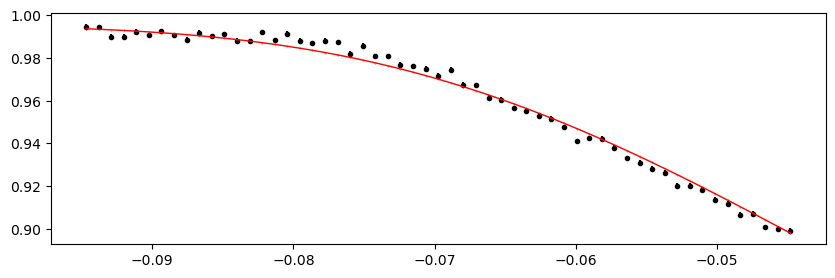

2770.9710588955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.27it/s]


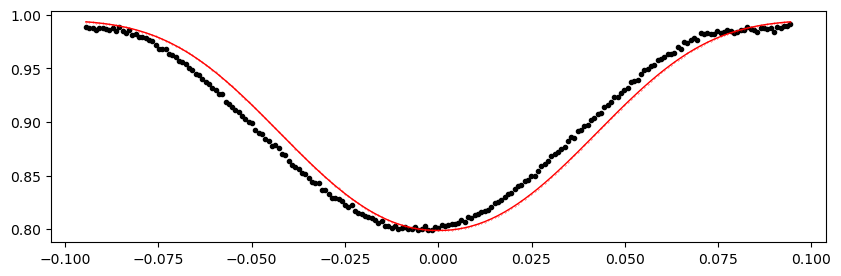

2772.530289895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.09it/s]


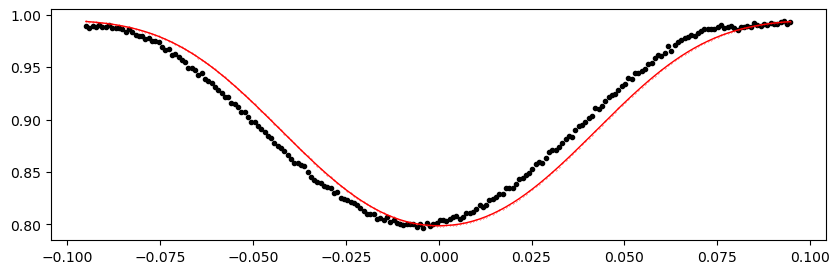

2774.089520895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.04it/s]


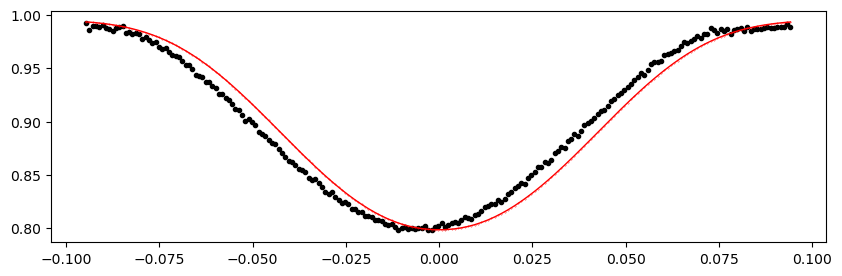

2775.648751895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.00it/s]


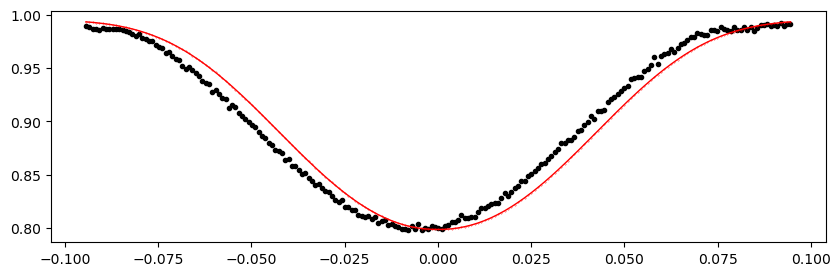

2777.207982895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.69it/s]


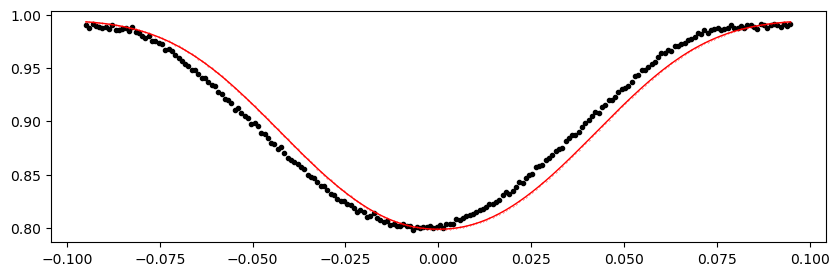

2778.7672138955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.99it/s]


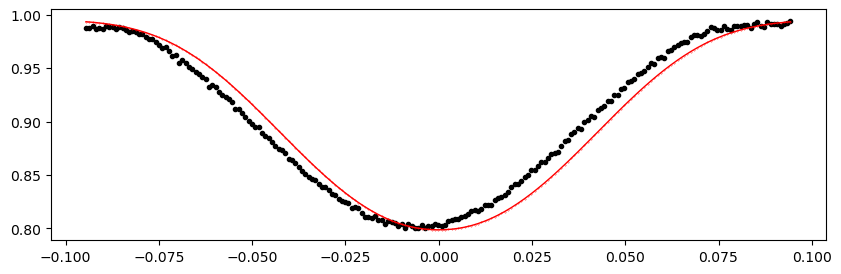

2780.326444895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.58it/s]


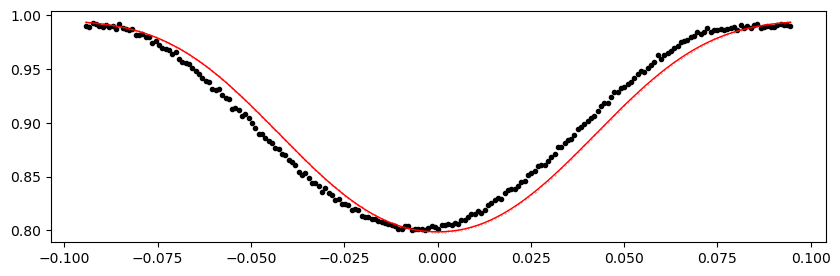

2781.885675895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.20it/s]


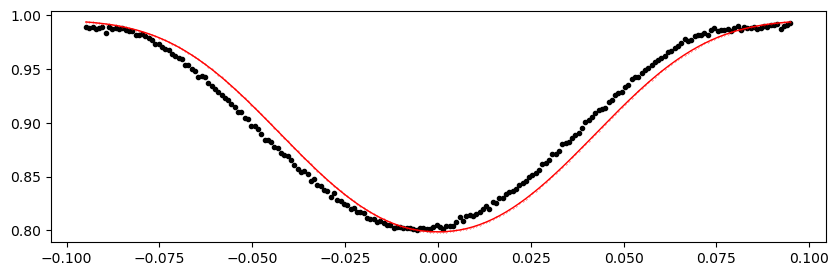

2783.444906895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.69it/s]


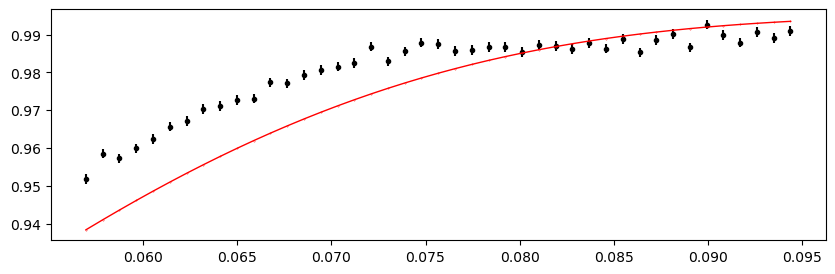

2785.004137895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.68it/s]


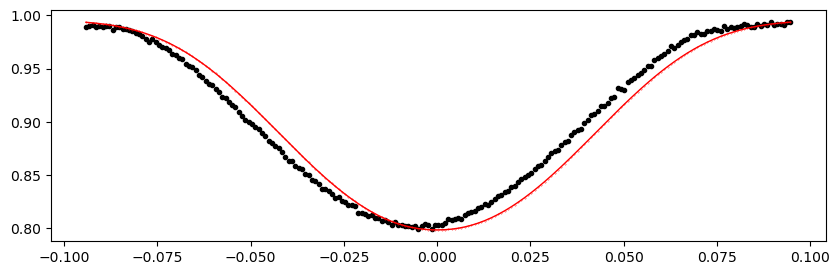

2786.5633688955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.22it/s]


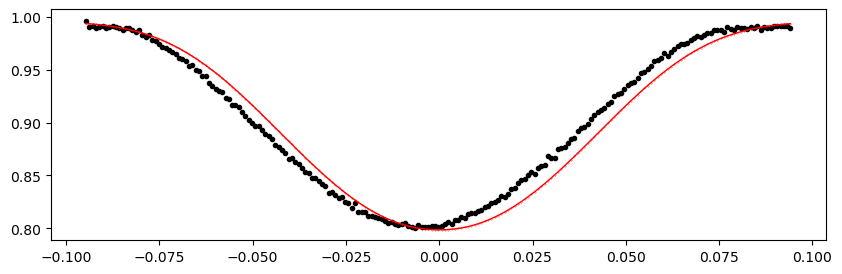

2788.122599895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.71it/s]


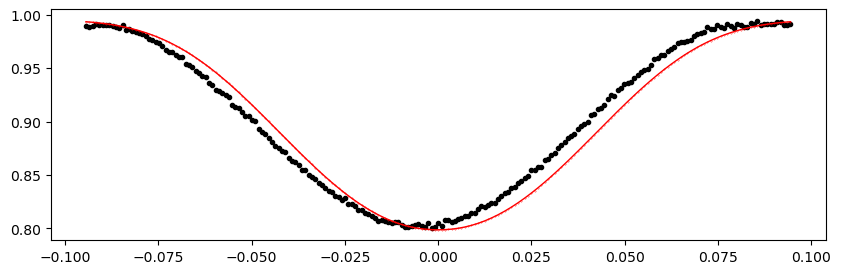

2789.681830895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.89it/s]


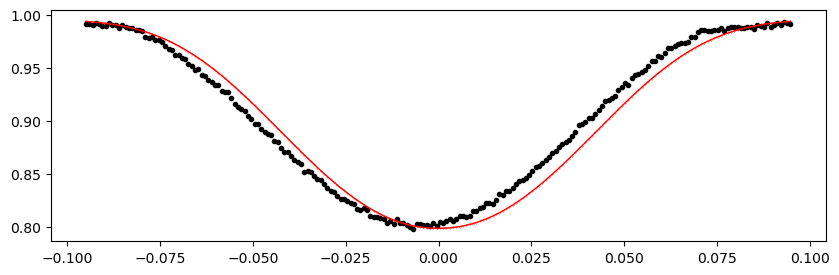

2791.241061895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1330.72it/s]


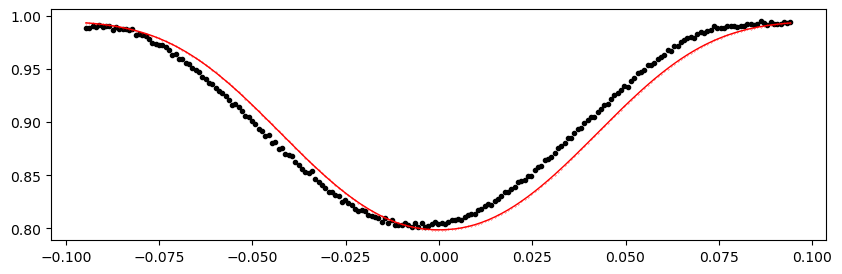

2792.800292895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.66it/s]


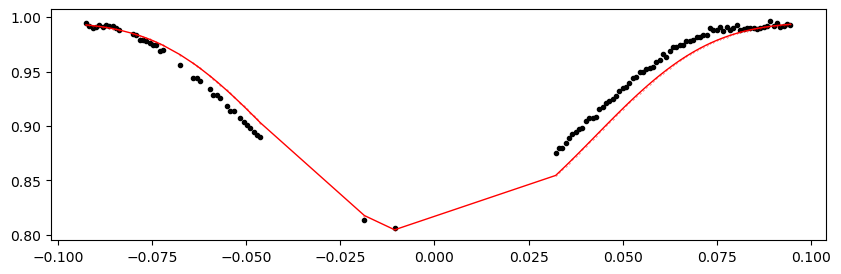

2794.3595238955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.08it/s]


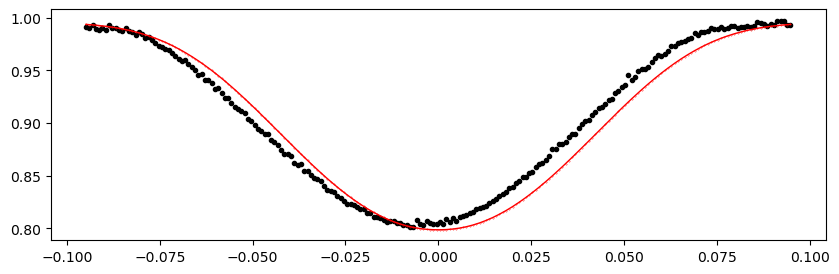

2795.918754895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.67it/s]


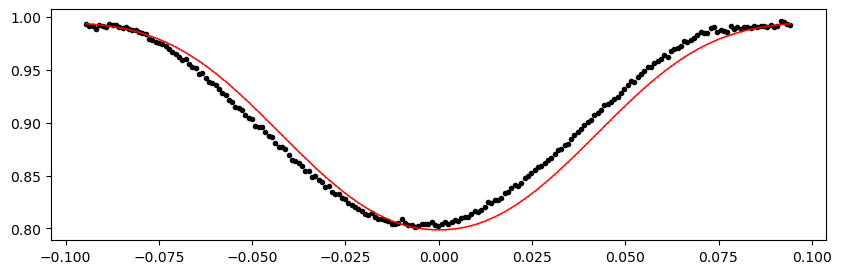

2797.477985895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1356.64it/s]


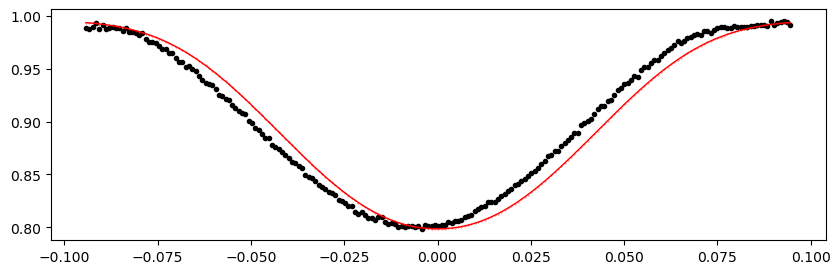

2799.037216895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.39it/s]


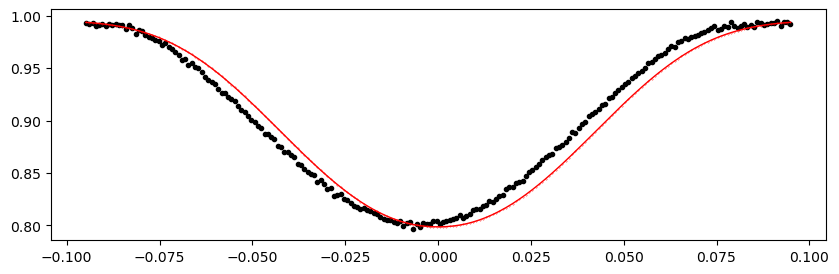

2800.596447895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.71it/s]


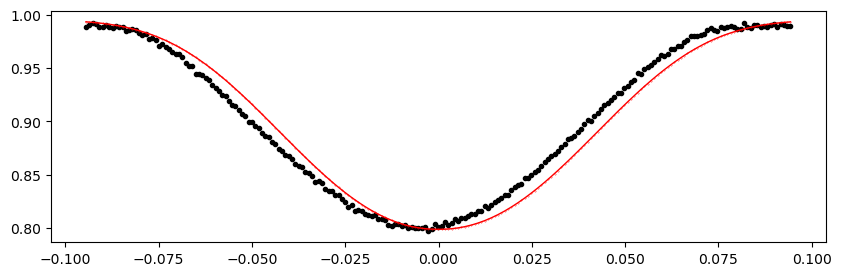

2802.1556788955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.22it/s]


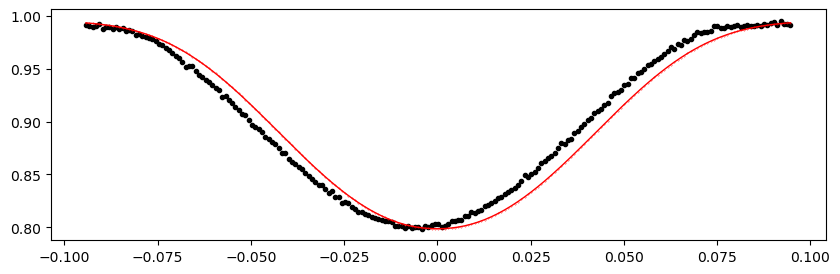

2803.714909895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.64it/s]


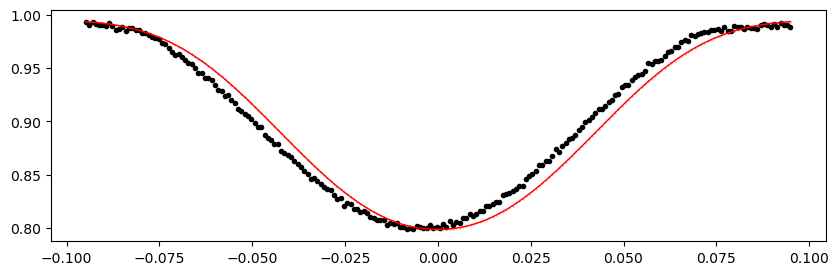

2805.274140895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.20it/s]


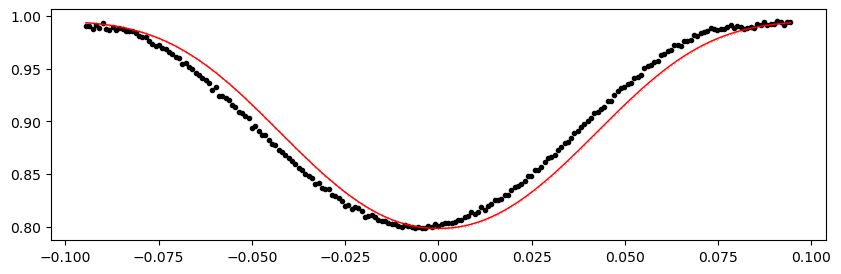

2806.833371895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.08it/s]


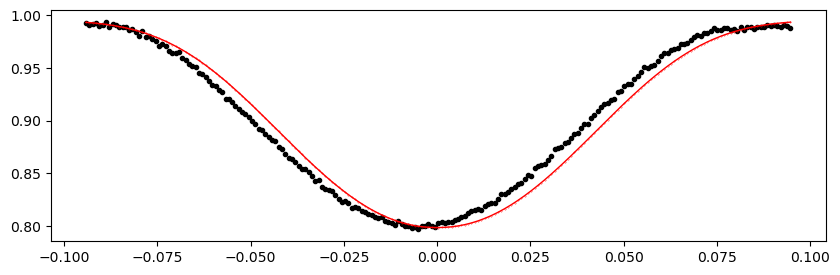

2808.392602895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1371.92it/s]


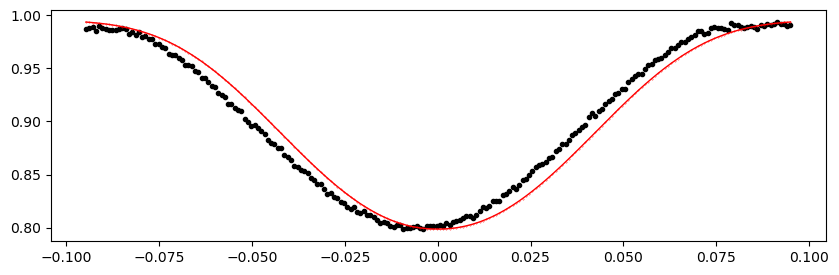

2809.9518338955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.15it/s]


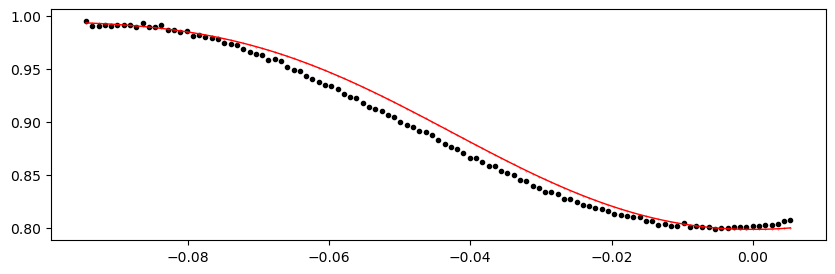

2811.511064895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.77it/s]


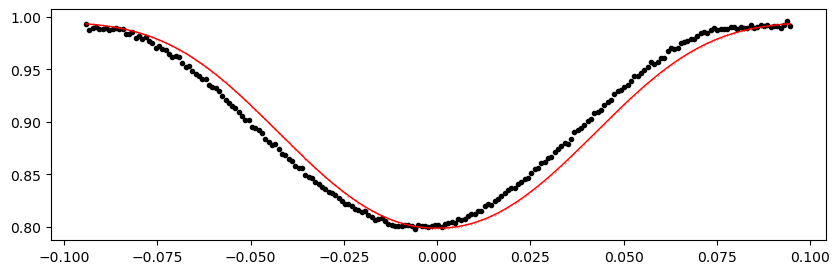

2813.070295895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.05it/s]


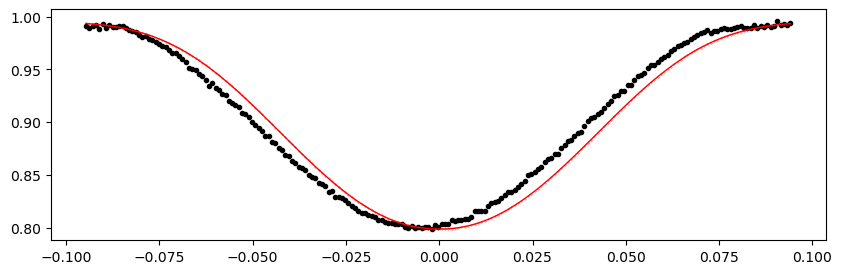

2814.629526895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.49it/s]


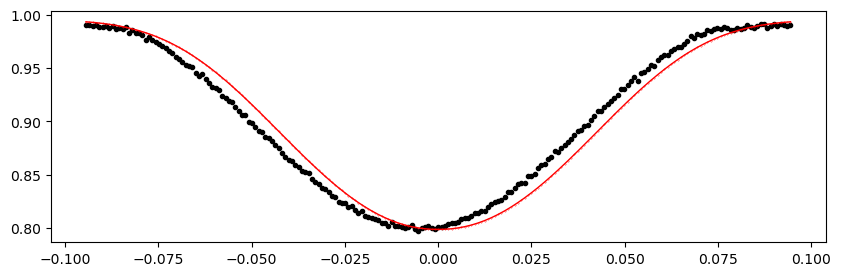

2816.188757895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.87it/s]


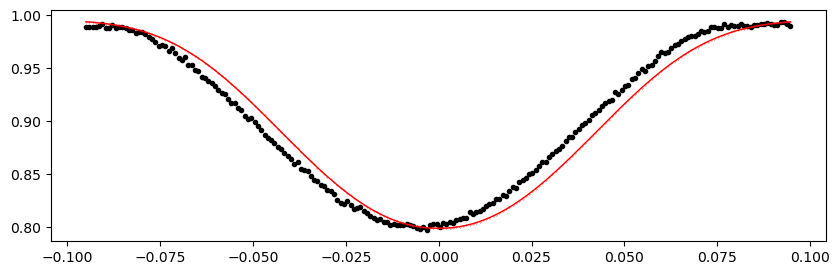

2817.7479888955986 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.61it/s]


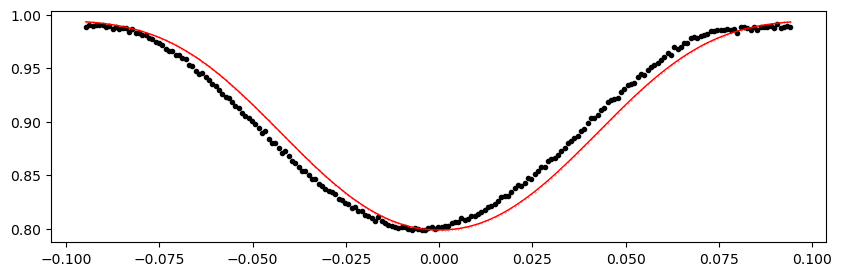

2819.307219895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.60it/s]


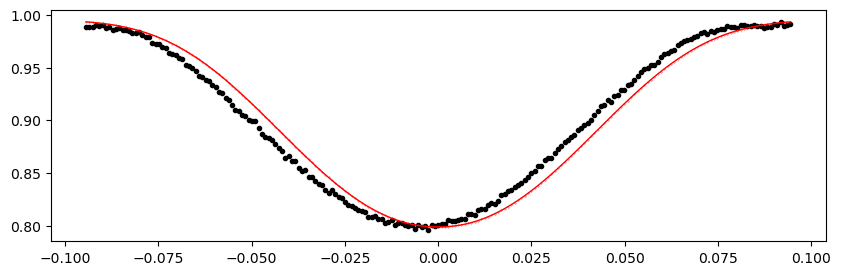

2820.866450895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.08it/s]


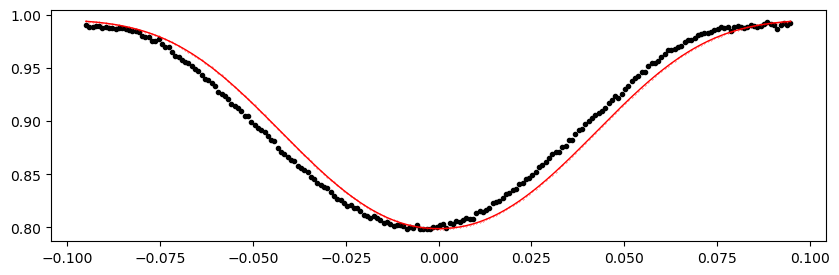

2822.425681895599 0.9952805328380019 -0.19658210963617523 0.13786921181808892


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.25it/s]


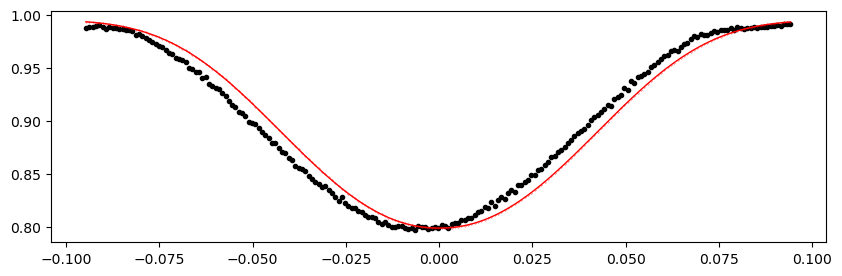

In [84]:
%matplotlib inline

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path)
!$NOTIFY_CMD "Individual primary eclipses fit done"

Fitting individual secondary eclipses...
Creating new manifest file
1683.4074363955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1311.35it/s]


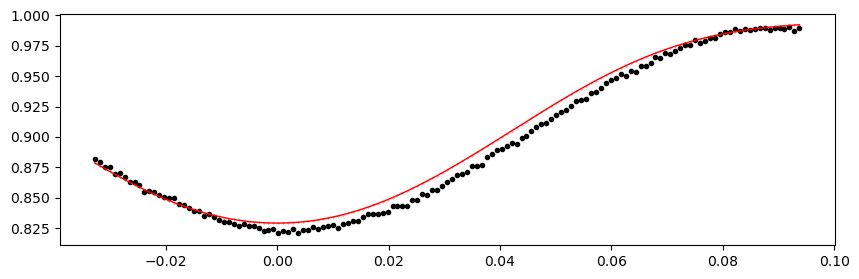

1684.9666673955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.04it/s]


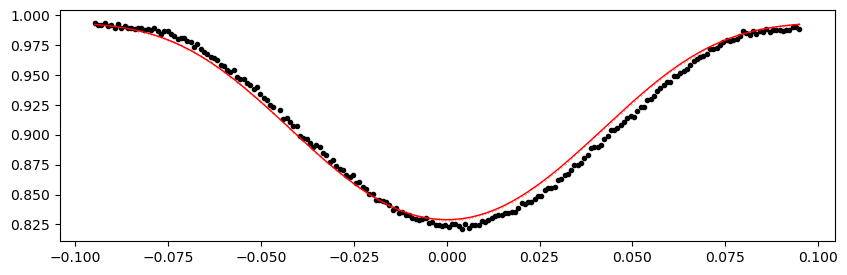

1686.5258983955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.16it/s]


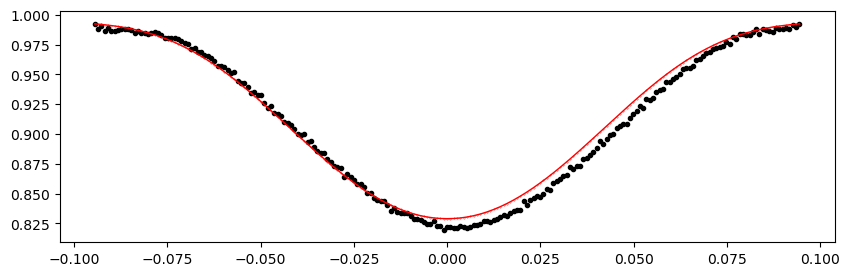

1688.0851293955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.51it/s]


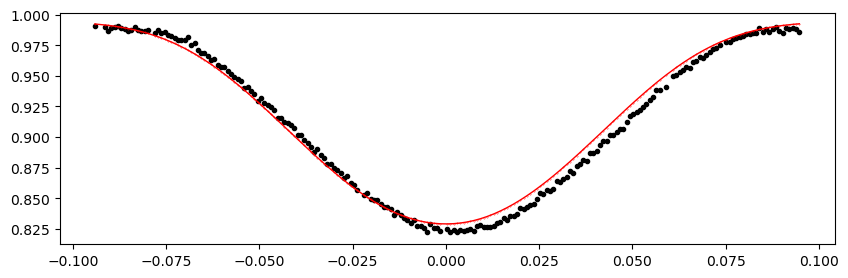

1689.6443603955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.05it/s]


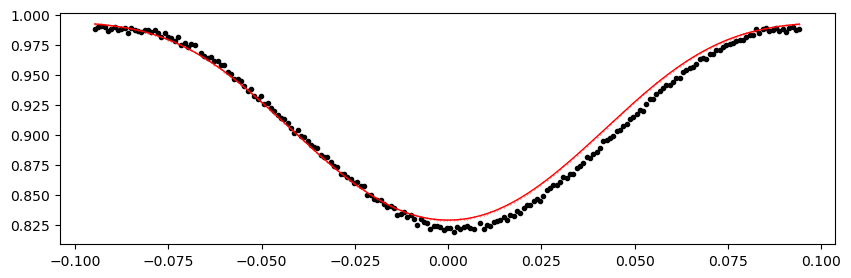

1691.2035913955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.31it/s]


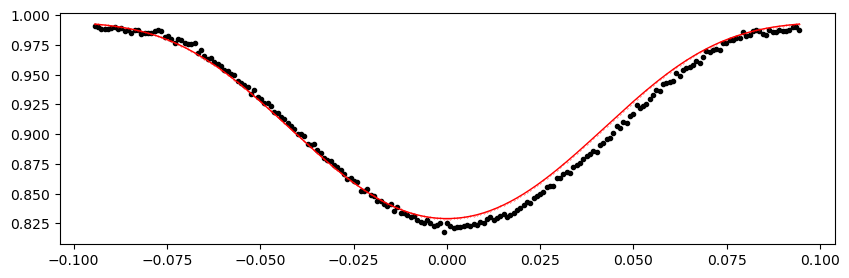

1692.7628223955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.27it/s]


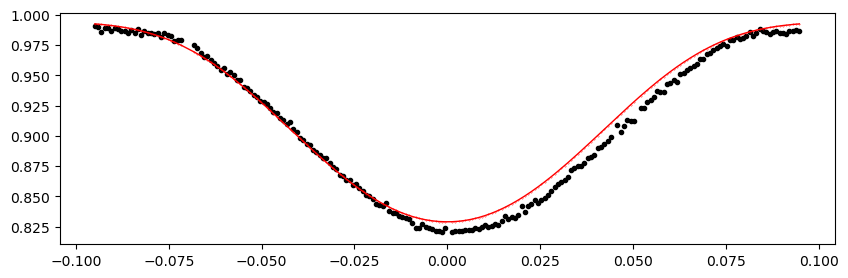

1694.3220533955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.03it/s]


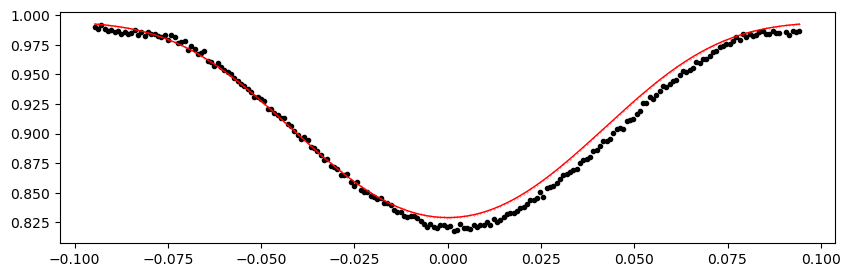

1695.8812843955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.76it/s]


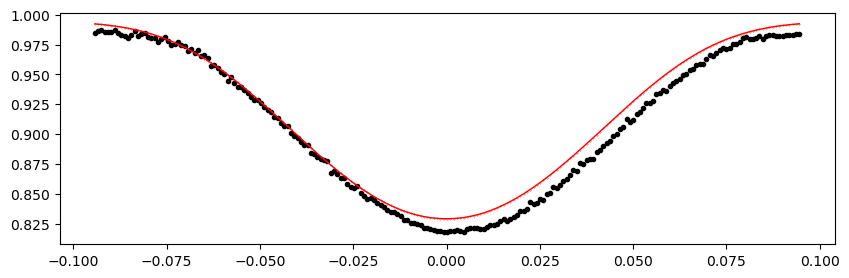

1697.4405153955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.70it/s]


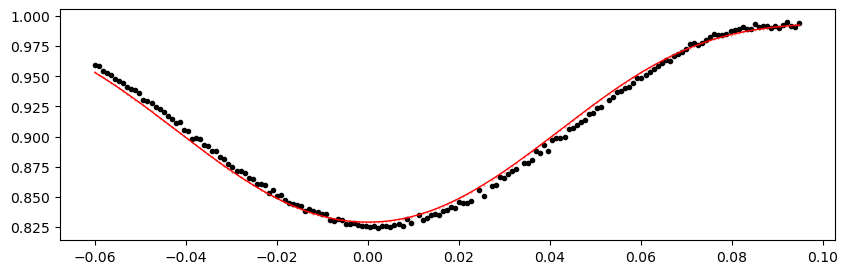

1698.9997463955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.33it/s]


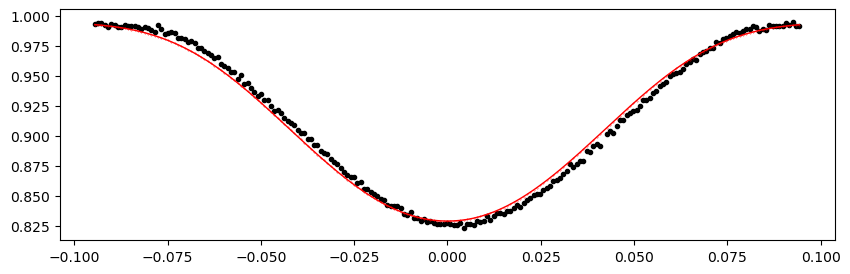

1700.5589773955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.36it/s]


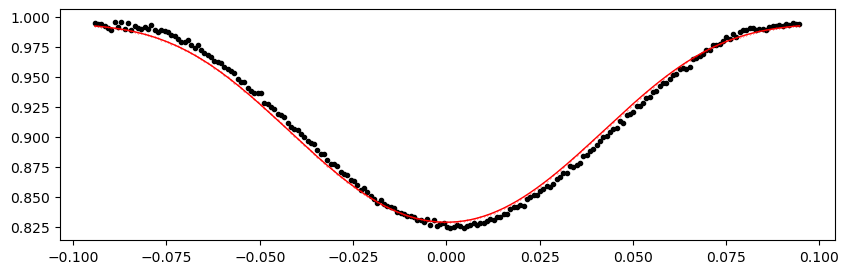

1702.1182083955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.45it/s]


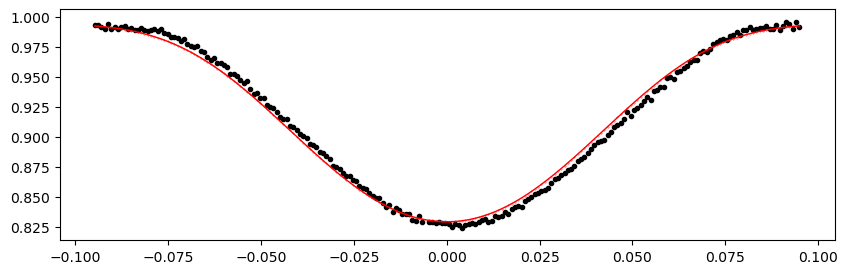

1703.6774393955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.04it/s]


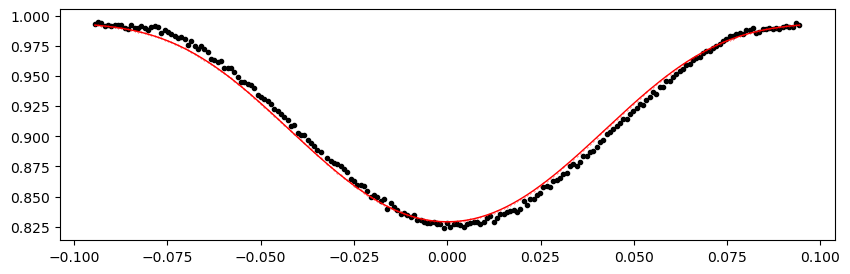

1705.2366703955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.14it/s]


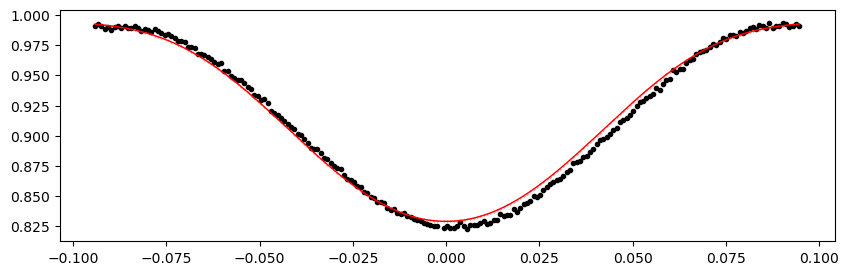

1706.7959013955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.24it/s]


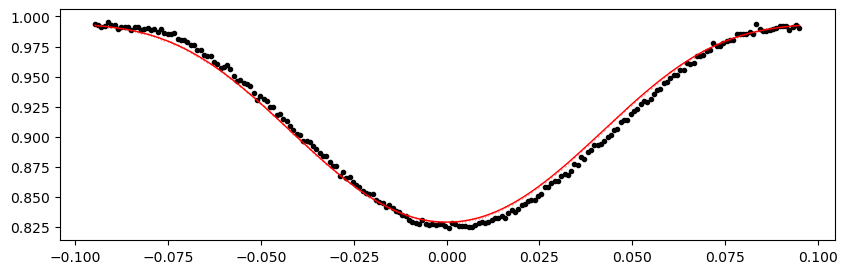

1708.3551323955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.76it/s]


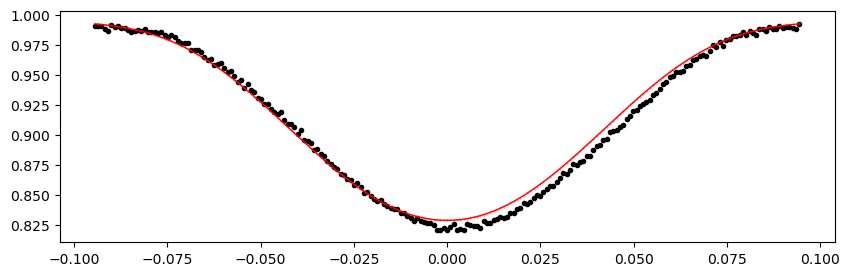

1709.9143633955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.27it/s]


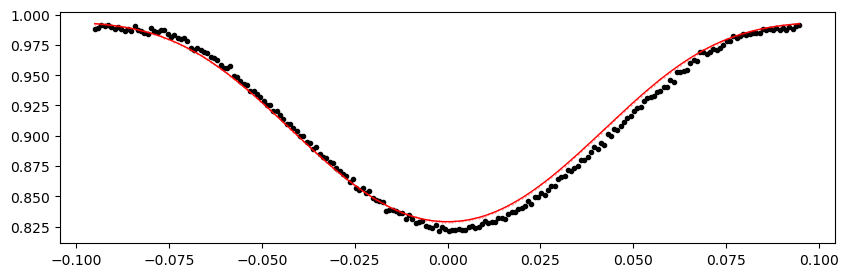

1711.4735943955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.25it/s]


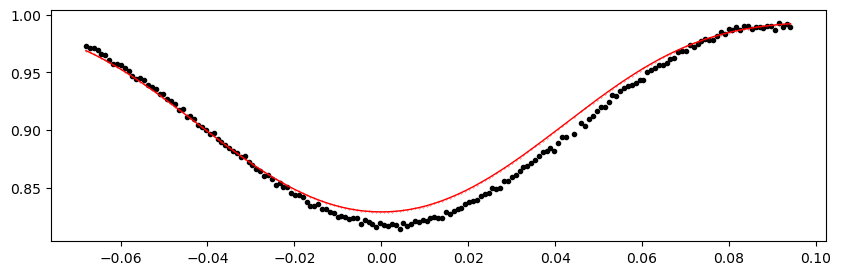

1713.0328253955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.95it/s]


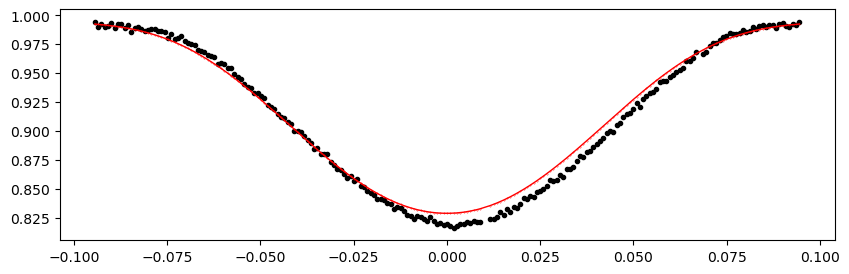

1714.5920563955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.65it/s]


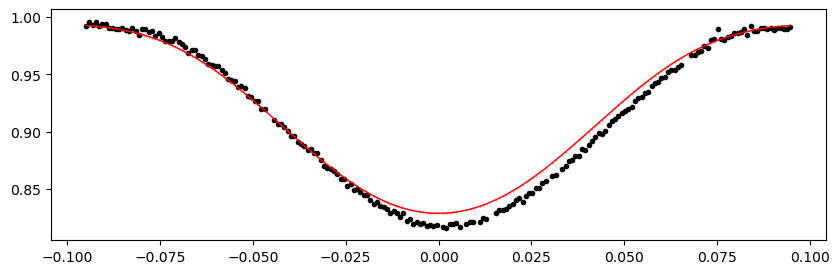

1716.1512873955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.88it/s]


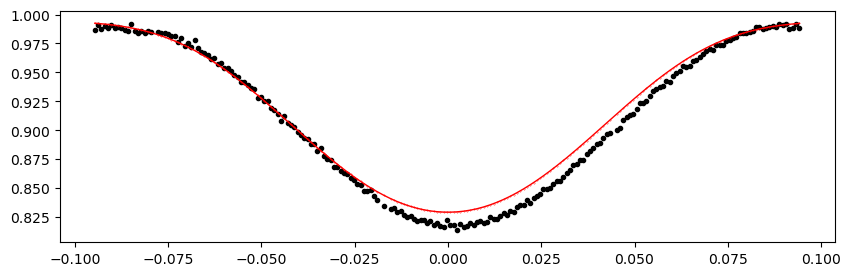

1717.7105183955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.10it/s]


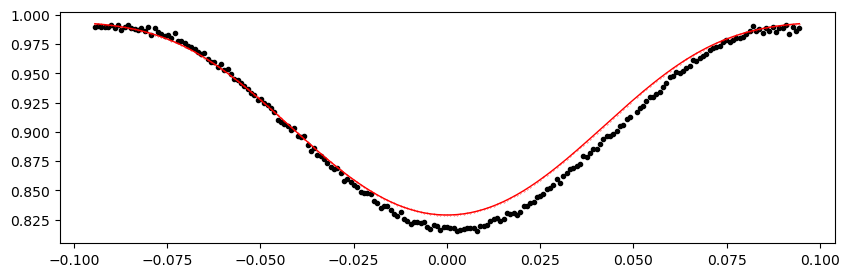

1719.2697493955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.37it/s]


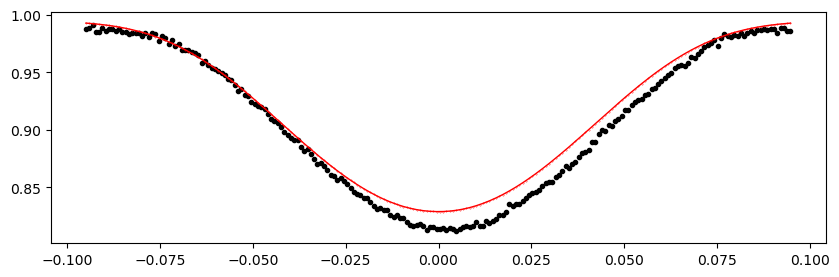

1720.8289803955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1366.13it/s]


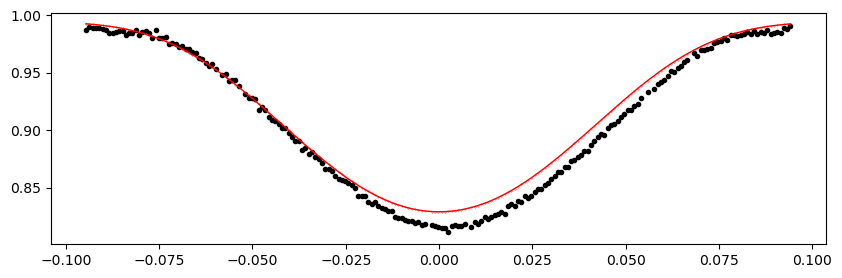

1722.3882113955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.14it/s]


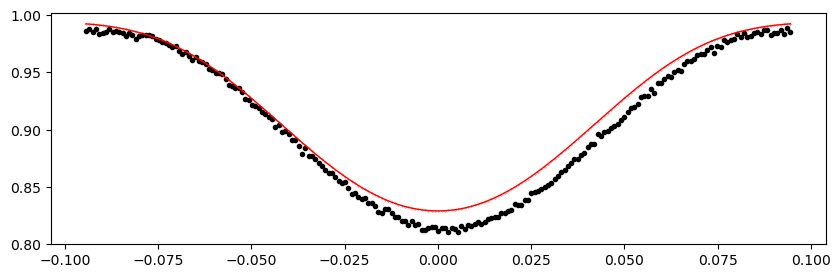

1723.9474423955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.29it/s]


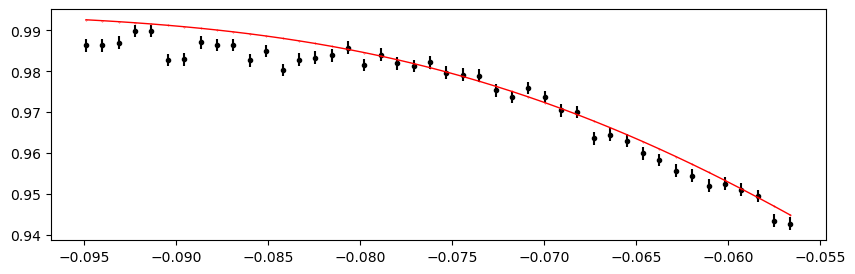

1725.5066733955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.30it/s]


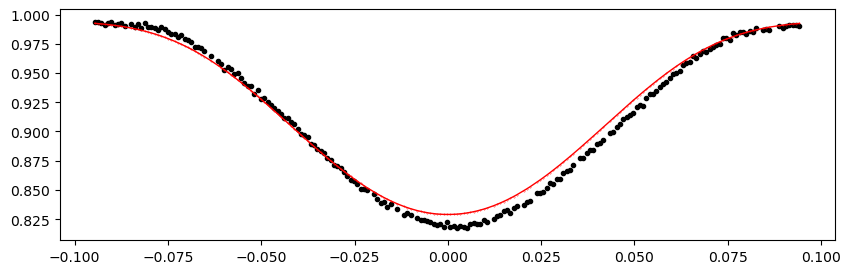

1727.0659043955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.10it/s]


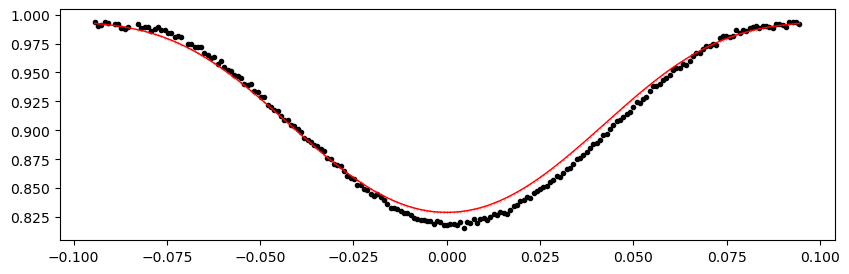

1728.6251353955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.93it/s]


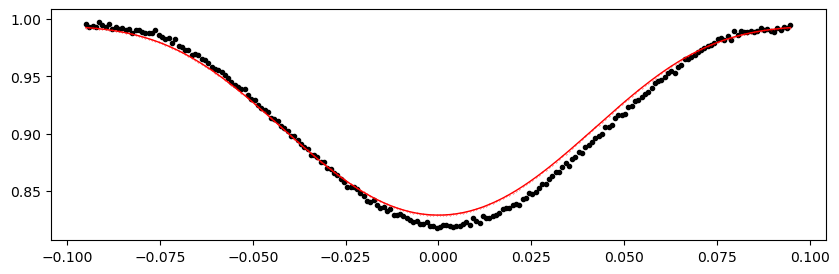

1730.1843663955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.18it/s]


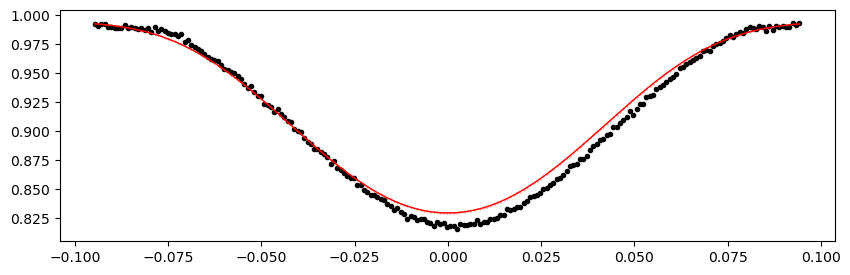

1731.7435973955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.20it/s]


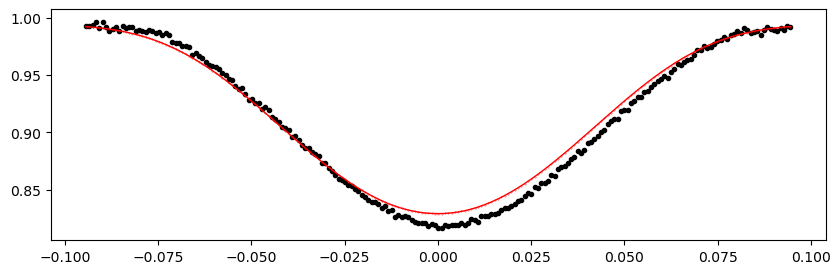

1733.3028283955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.48it/s]


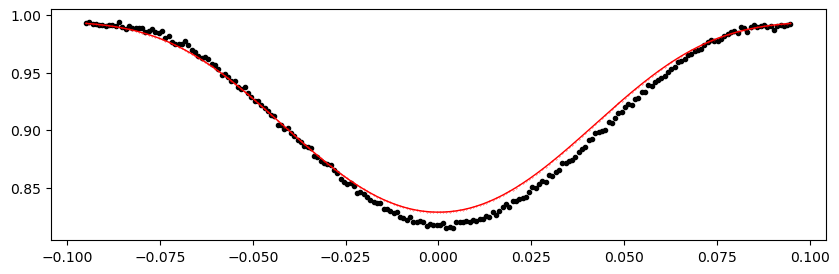

1734.8620593955989 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.46it/s]


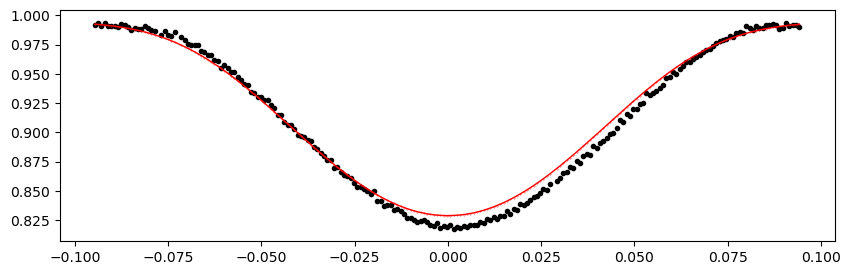

2420.9236993955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.69it/s]


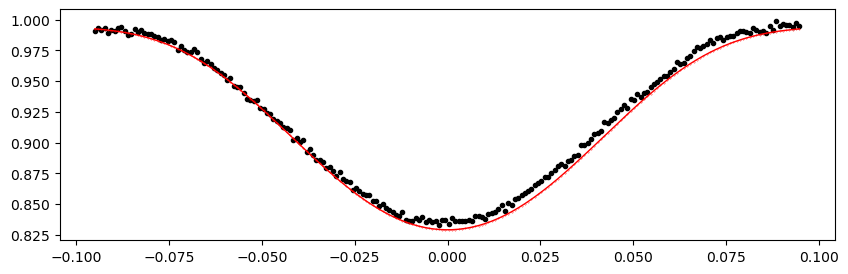

2422.482930395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.24it/s]


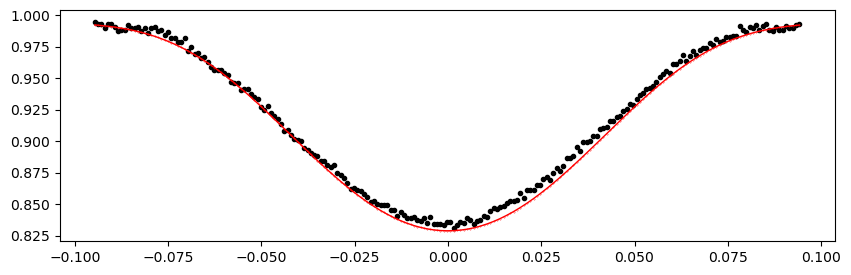

2424.0421613955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.73it/s]


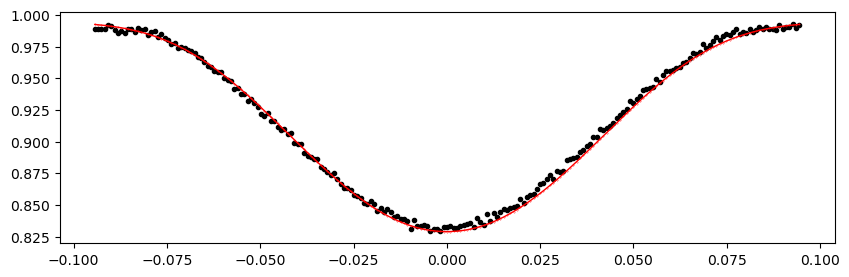

2425.601392395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.08it/s]


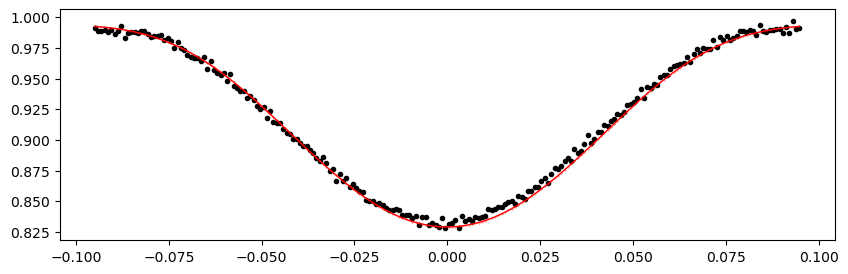

2427.160623395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.54it/s]


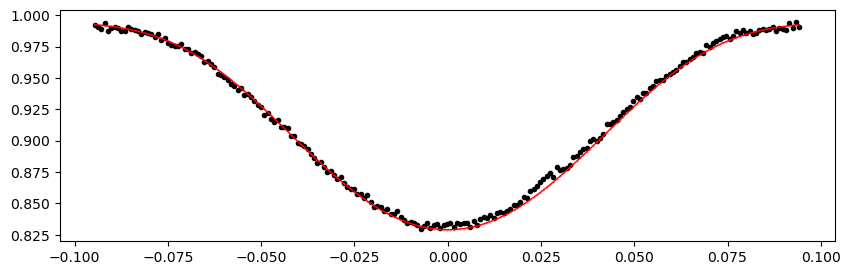

2428.7198543955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.45it/s]


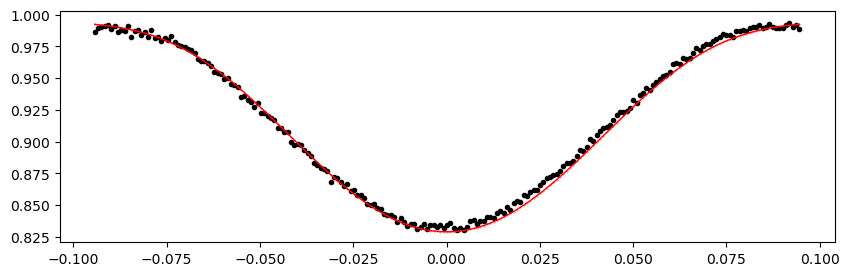

2430.279085395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1365.18it/s]


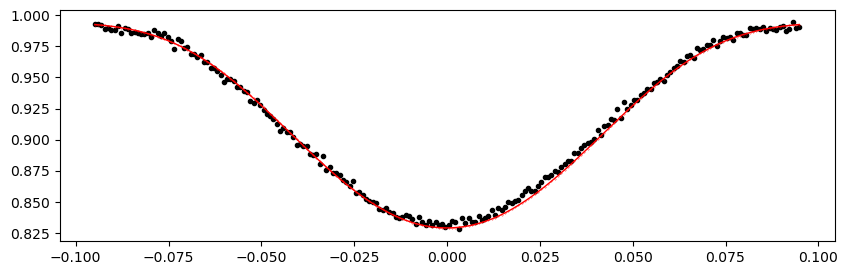

2431.8383163955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1361.16it/s]


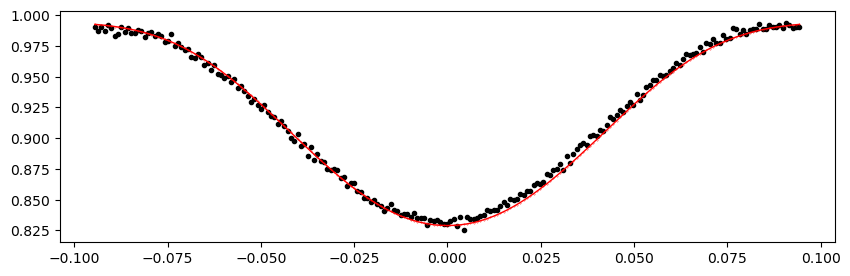

2434.956778395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.71it/s]


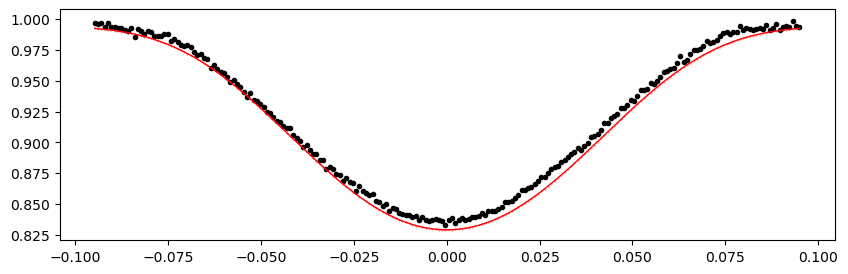

2436.5160093955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.14it/s]


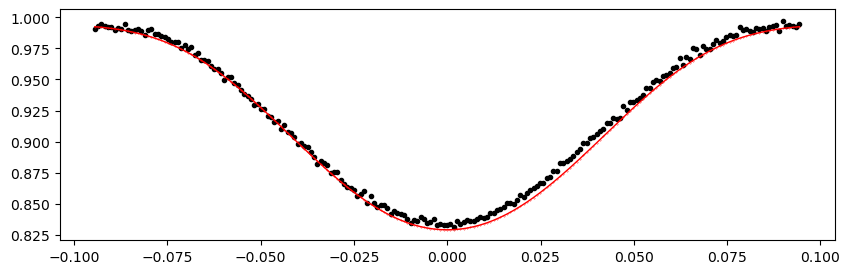

2438.075240395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.51it/s]


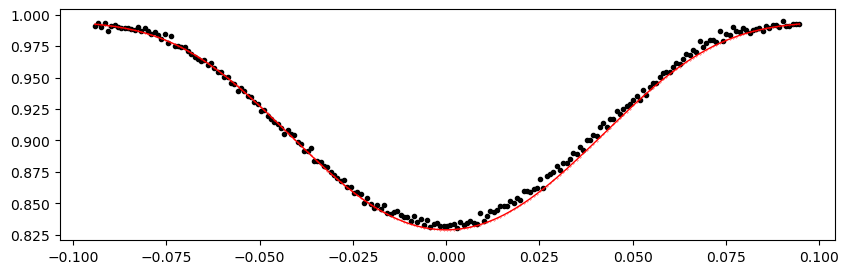

2439.6344713955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.54it/s]


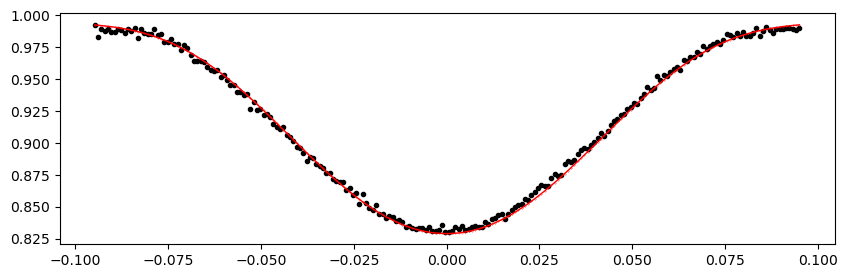

2441.193702395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1355.21it/s]


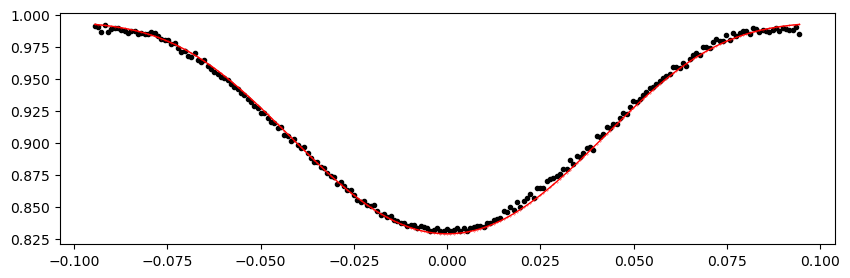

2442.752933395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.98it/s]


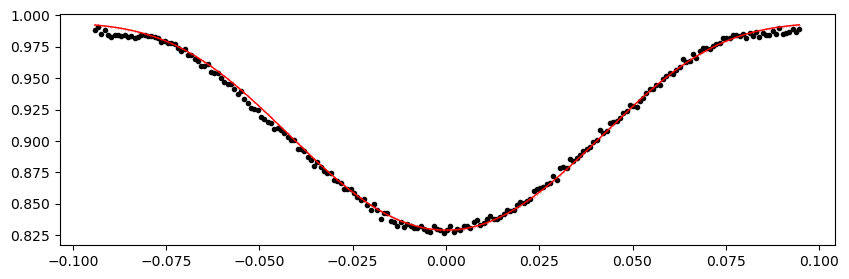

2444.3121643955988 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.37it/s]


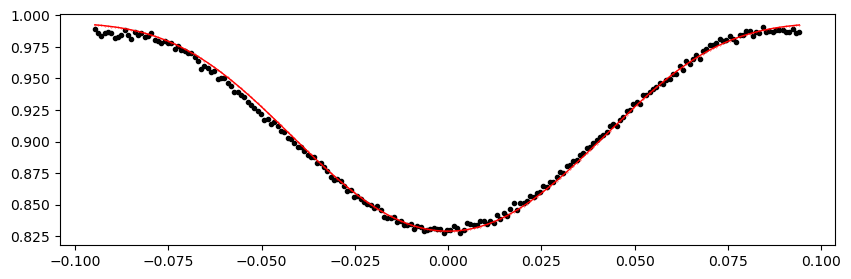

2445.871395395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.12it/s]


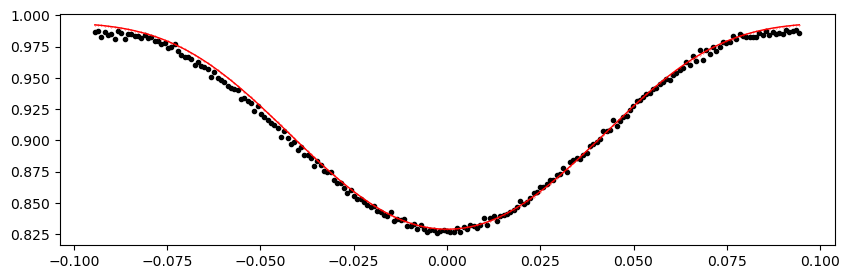

2770.191443395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1355.95it/s]


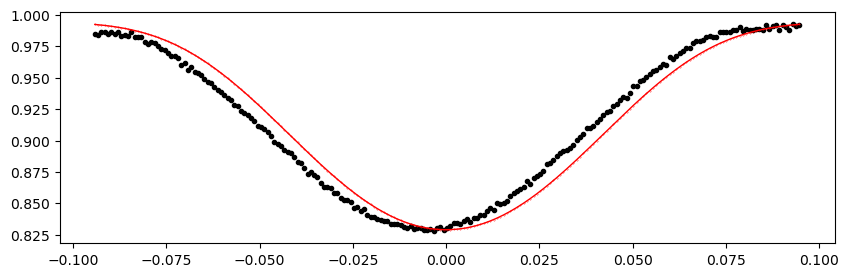

2771.7506743955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.40it/s]


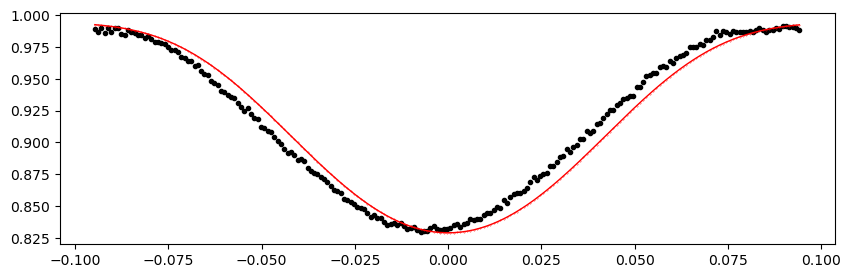

2773.309905395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.44it/s]


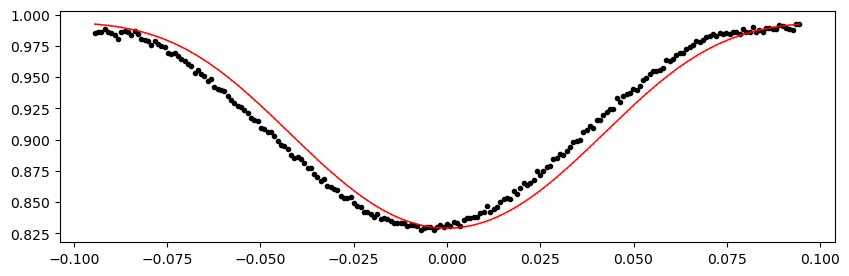

2774.8691363955986 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.29it/s]


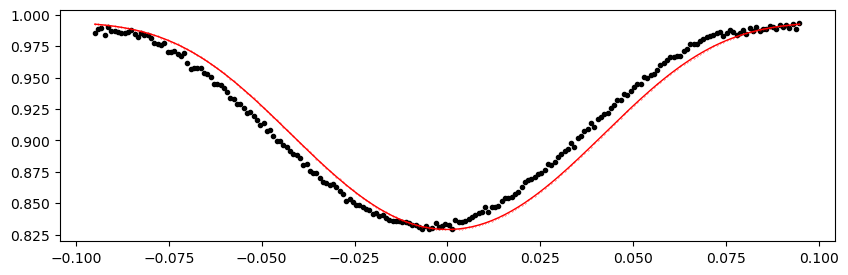

2776.428367395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1356.80it/s]


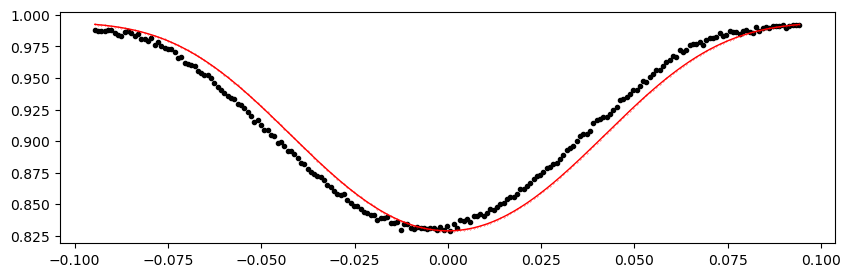

2777.987598395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.75it/s]


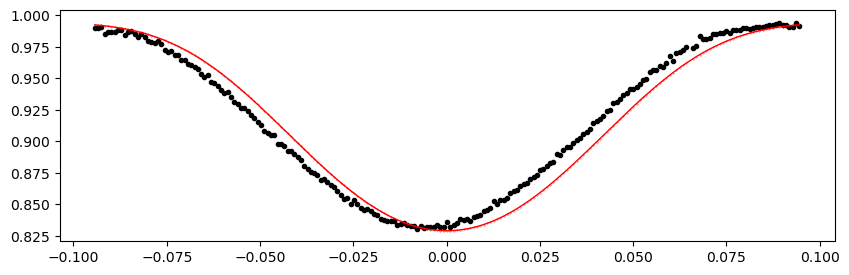

2779.5468293955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1364.32it/s]


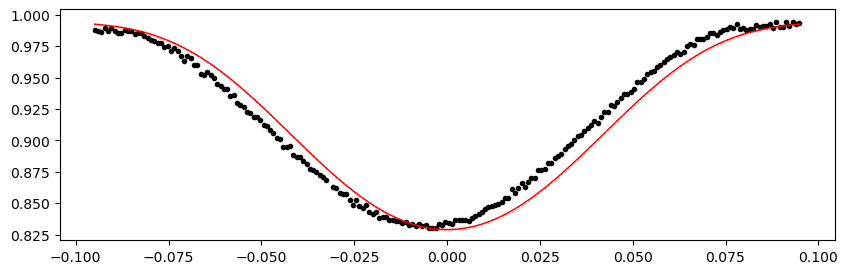

2781.106060395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.39it/s]


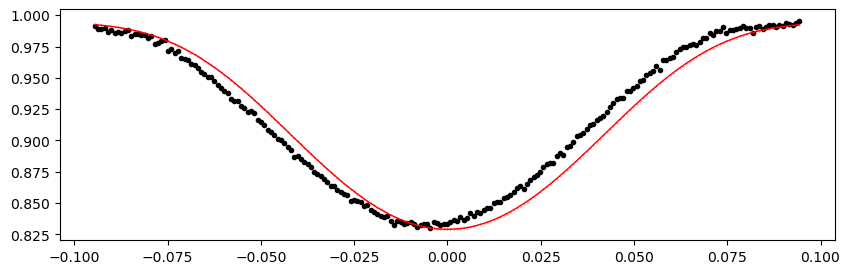

2784.224522395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.02it/s]


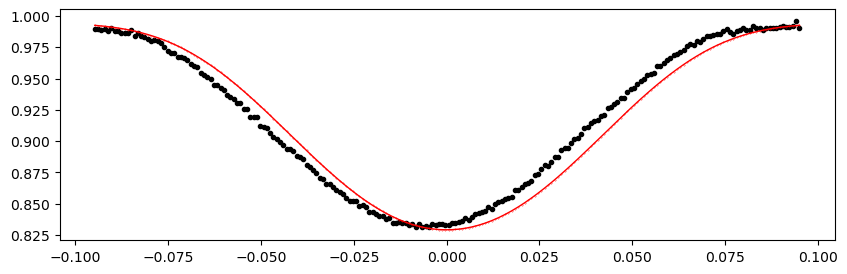

2785.783753395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.76it/s]


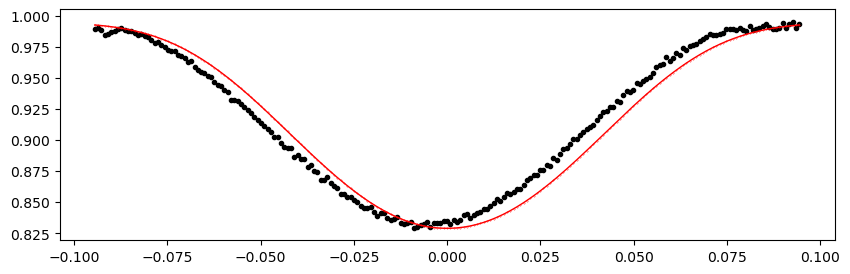

2787.3429843955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.88it/s]


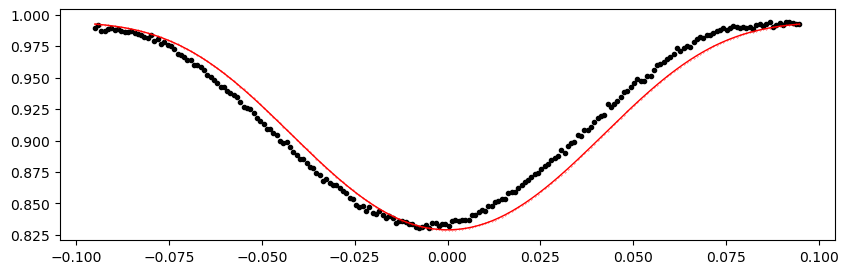

2788.902215395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.46it/s]


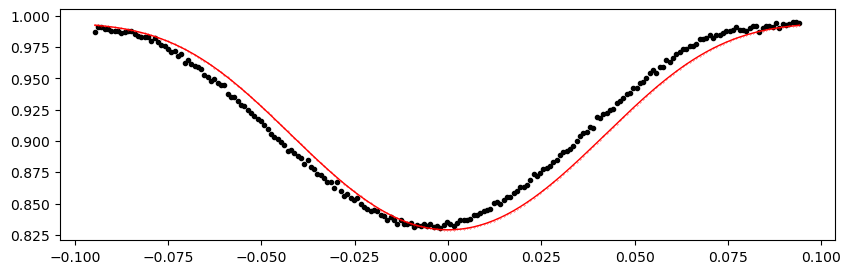

2790.4614463955986 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1302.28it/s]


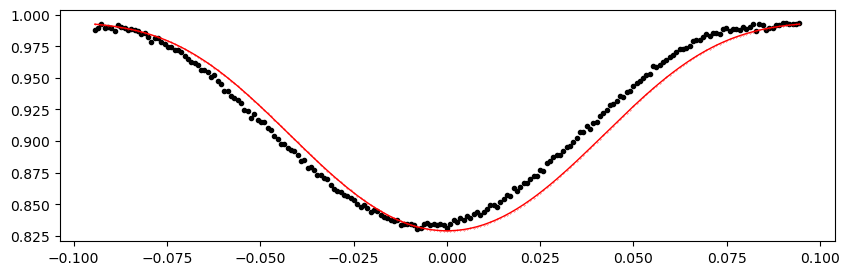

2792.020677395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1306.52it/s]


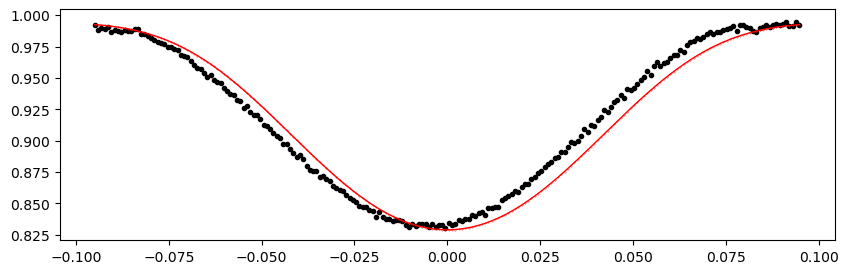

2793.579908395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1306.26it/s]


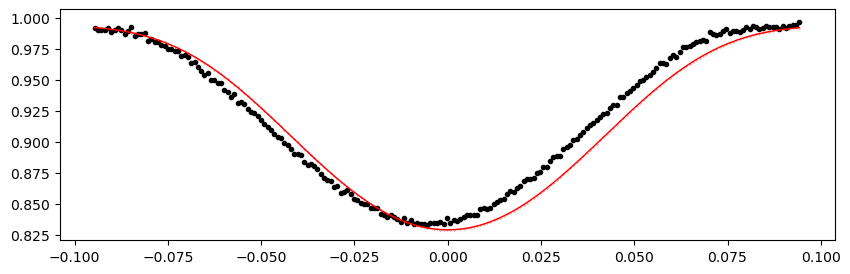

2795.1391393955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.13it/s]


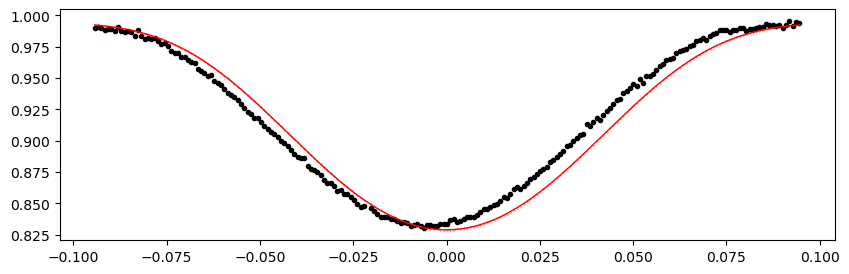

2798.2576013955986 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.35it/s]


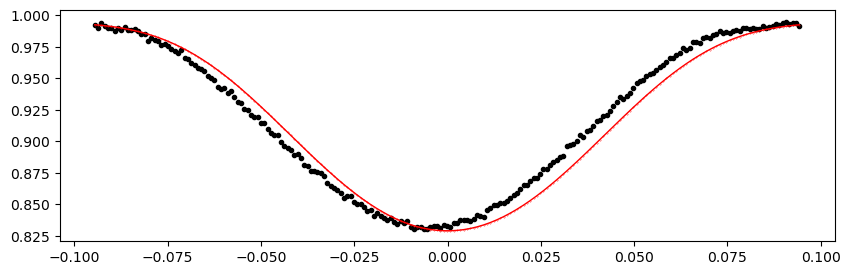

2799.816832395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.41it/s]


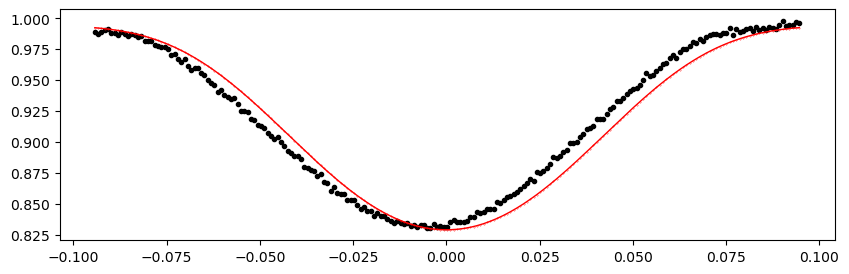

2801.376063395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.11it/s]


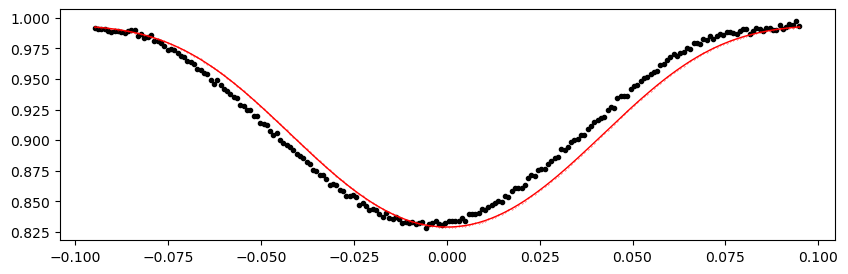

2802.9352943955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1355.05it/s]


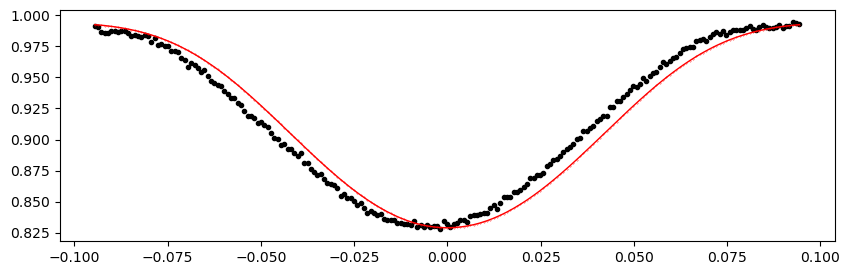

2804.494525395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.17it/s]


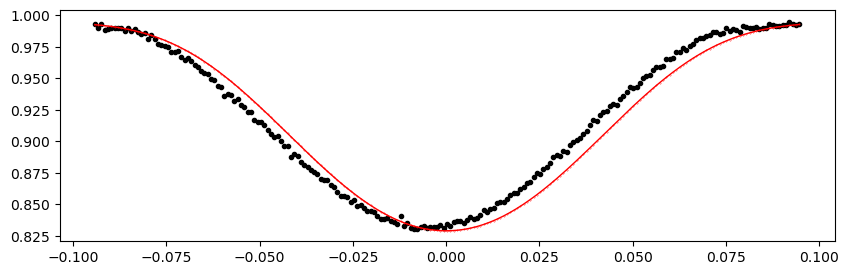

2806.0537563955986 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1360.52it/s]


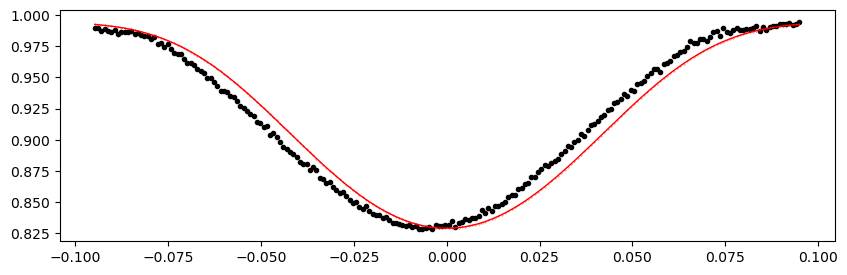

2807.612987395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.36it/s]


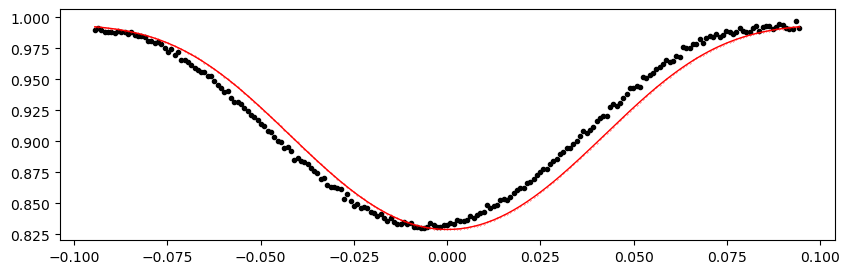

2809.172218395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.52it/s]


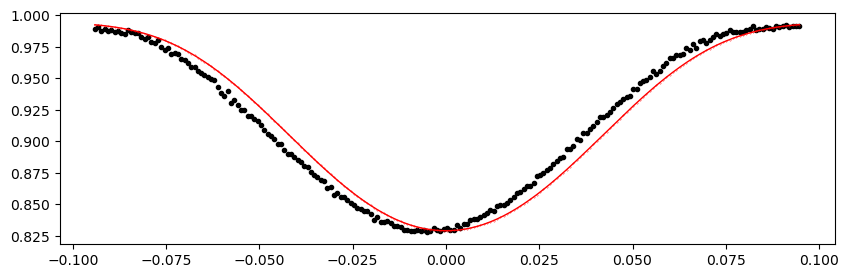

2812.290680395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.66it/s]


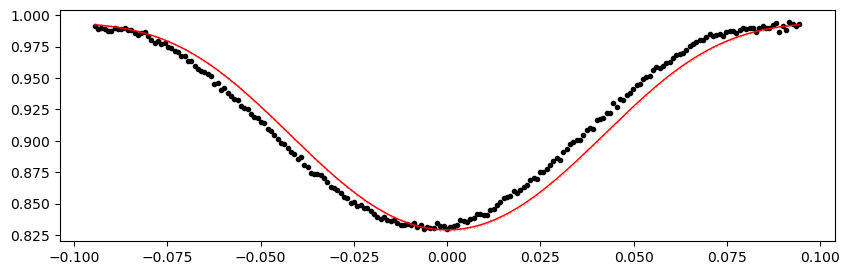

2813.8499113955986 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.67it/s]


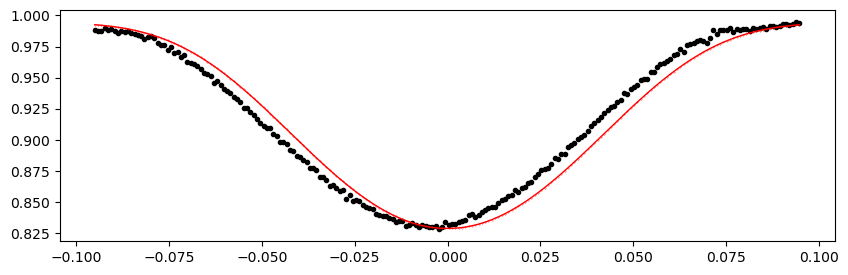

2815.409142395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.17it/s]


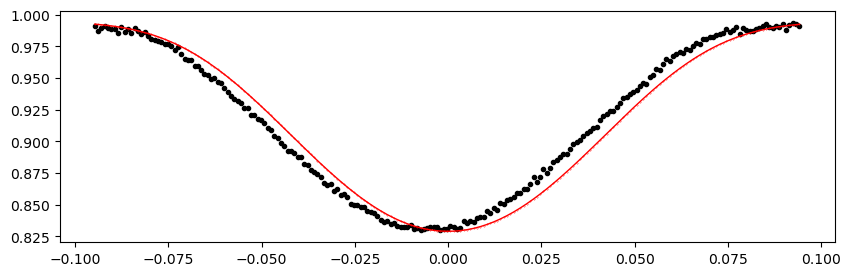

2816.968373395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.19it/s]


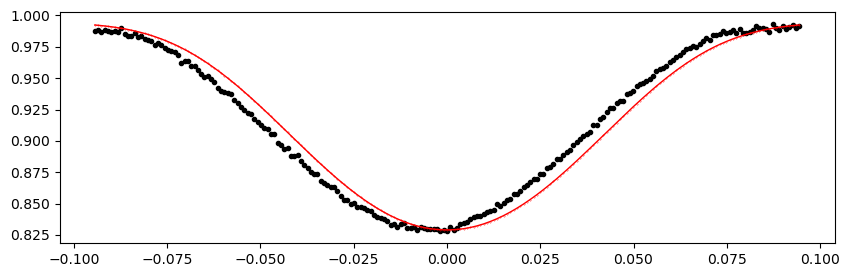

2818.5276043955987 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.61it/s]


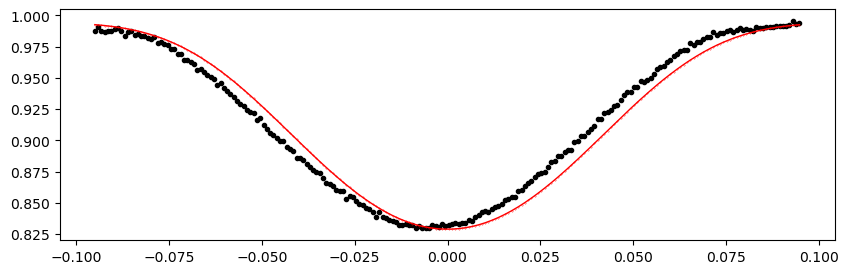

2820.086835395599 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.77it/s]


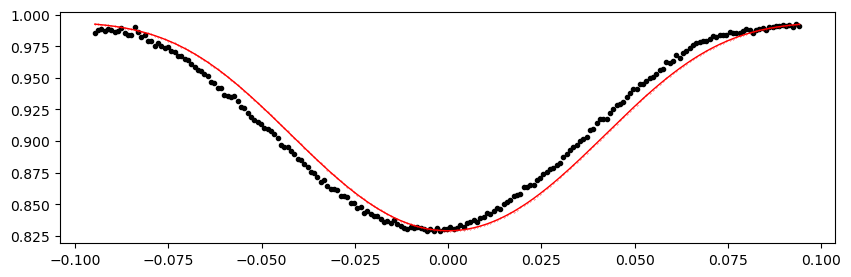

2821.6460663955986 0.9942509461053578 -0.16521715024221129 -0.3621991361211707


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1235.26it/s]


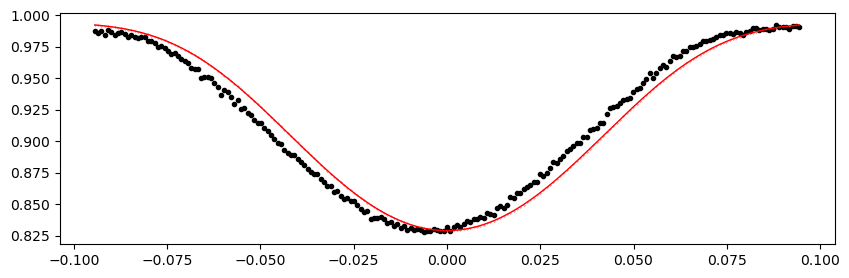

In [85]:
%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s)
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

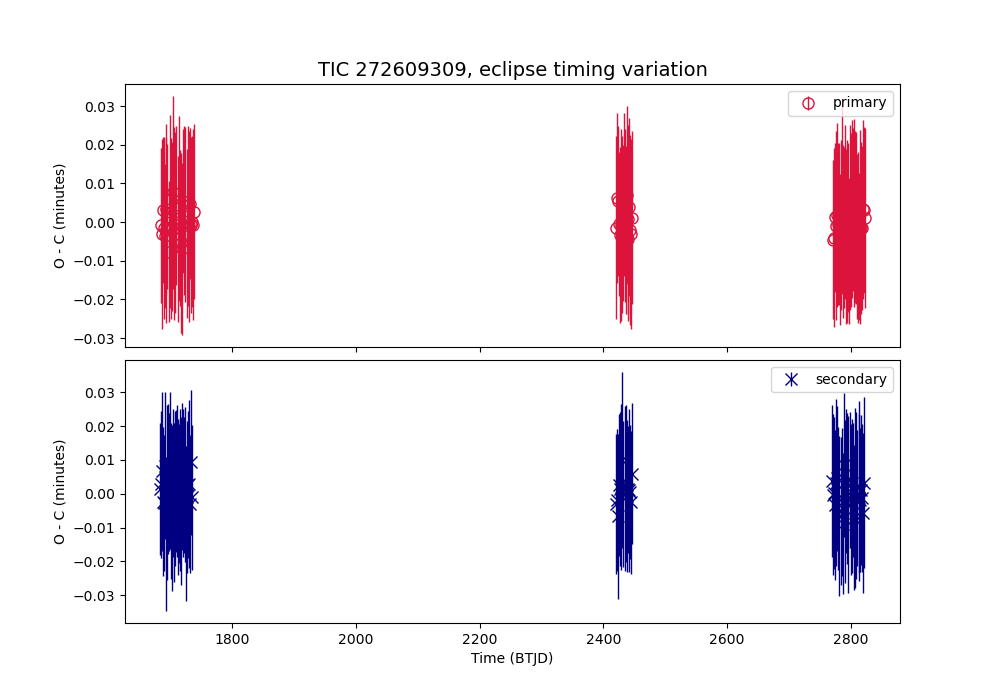

In [87]:
# %matplotlib inline
%matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

### O-C Plot, Zoom In

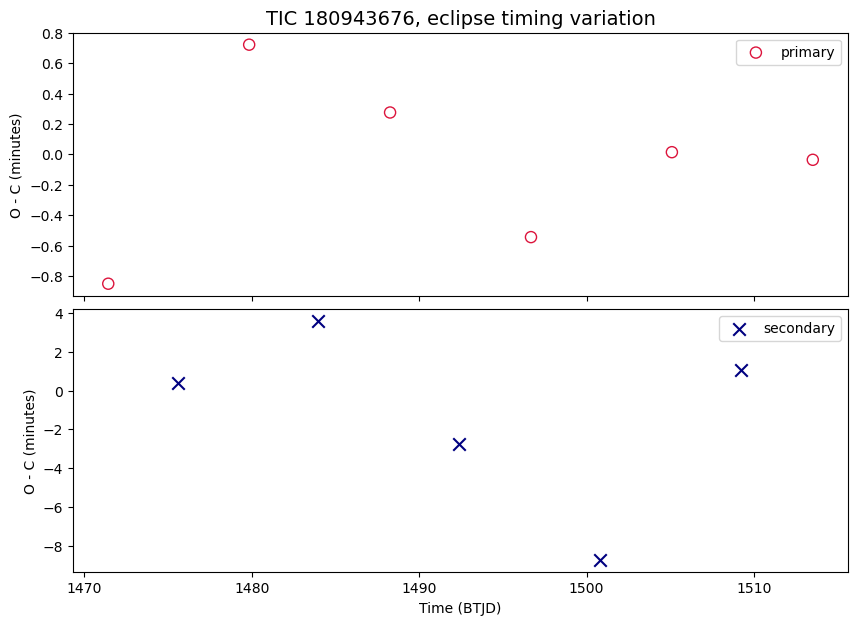

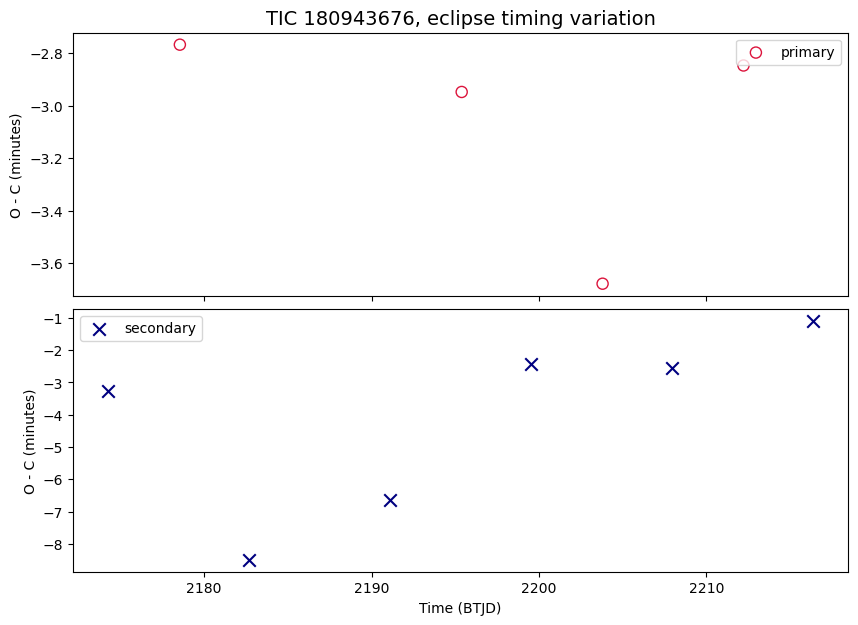

In [75]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] < 1600]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] < 1600]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


#
# Second chunk
#

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[in_df_primary['epoch'] > 1600]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[in_df_secondary['epoch'] > 1600]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


## make a periodogram 

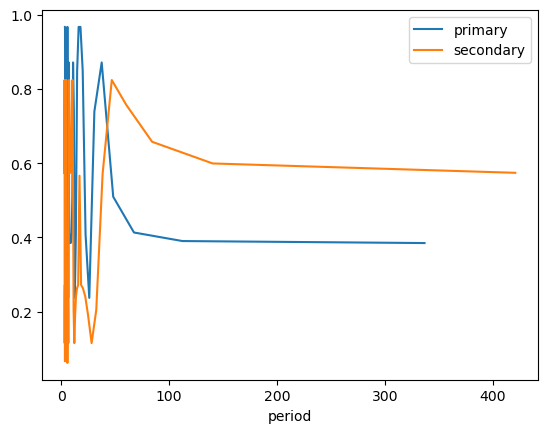

In [76]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots()

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.show()

## Results Summary

In [82]:
# FILL-IN the ETV results / comments
has_etv = "FP"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "FP, as ETV Period ~= SB Period. VSX entry refers to a nearby EB with similar brightness."

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                         180943676
has_etv                                                                                            FP
comments     FP, as ETV Period ~= SB Period. VSX entry refers to a nearby EB with similar brightness.
period                                                                                       8.418147
depth_pct_p                                                                                      8.28
depth_pct_s                                                                                      0.39
epoch_p                                                                                     1471.4196
epoch_s                                                                                     1475.5596
num_sectors                                                                                         4
time_span                                                                                      759.29
time_start                                                                                    1468.27
time_end                                                                                      2227.57


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
180943676,FP,"FP, as ETV Period ~= SB Period. VSX entry refers to a nearby EB with similar brightness.",8.418147,8.28,0.39,1471.4196,1475.5596,4,759.29,1468.27,2227.57

